In [1]:
from IPython.display import display, Image, clear_output

# Comprehensive Lipidome Automation Workflow (CLAW)

Welcome to CLAW, a tool designed to facilitate and optimize the processing of lipidomic MRM data. This Jupyter notebook encapsulates a suite of tools that streamline the various stages of lipidomics data analysis.

Our toolset enables users to efficiently process MRM data files in the mzML format. Upload a file and CLAW will parse the data into a structured Pandas dataframe. This dataframe includes critical information like sample_ID, MRM transition, and signal intensity. Furthermore, our tool aligns each MRM transition with a default or custom lipid_database for accurate and swift annotation.

Moreover, CLAW is equipped with an OzESI option, a tool to elucidate the double bond location in lipid isomers. This feature allows users to input OzESI data and pinpoint the precise location of double bonds in isomeric lipids. Users have the flexibility to select which double bond locations they want to analyze. Following this, CLAW autonomously predicts potential m/z values and cross-references these predictions with sample data, ensuring a comprehensive and meticulous analysis.

With automation at its core, CLAW eliminates the need for manual data processing, significantly reducing time expenditure. It is a robust and invaluable tool for handling large volumes of lipid MRM data, accelerating scientific discovery in the field of lipidomics.

In [2]:
#Import all the necessary python libraries
import pymzml
import csv
import os
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import json
from scipy.integrate import trapz

#Import all the necessary CLAW libraries
import create_directory
import CLAW
import matplotlib.pyplot as plt
import warnings

import re
from sklearn.mixture import GaussianMixture
import tqdm

# Suppress all warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Directory and File Management
For structured data management and efficient workflow, the system first ensures the presence of an output directory. If such a directory already exists you can skip this step.

In [3]:
# # Create the output directory. If it already exists you can skip this step.
# create_directory.create_project_folder()


The name of the project is defined next. This is important as the created directory will bear this name, allowing users to manage and identify their data with ease.

After the mzML files are uploaded to the designated mzML folder, the next block of code segregates these files based on their characteristics. More specifically, it filters the files and transfers them to respective folders named 'o3on' and 'o2only'.

In [4]:
name_of_project = 'FaceFats'
#After you load mzml files to mzml folder. this will filter the files and move them to o3on and o2only folders
create_directory.filter_o3mzml_files(name_of_project)

One or both of the destination directories 'Projects/FaceFats/o3on' and 'Projects/FaceFats/o2only' do not exist.


## Pre-Parsing Setup
The following block of code takes the preset variable values and uses them to parse the mzML files. The parsed data, including the sample ID, MRM transitions, and intensities, is stored in a pandas dataframe for easy manipulation and analysis.

The function CLAW.parsing_mzml_to_df takes several arguments. data_base_name_location is the location of the lipid database that contains information on lipid classes, fatty acid chains, and their corresponding MRM transitions. Project_Folder_data is the location of the mzML files for the samples to be analyzed. tolerance defines the acceptable range of deviation for the MRM transitions when matching them with the lipid database. The argument remove_std is a boolean that, when True, indicates to remove the MRM transitions that correspond to standards (internal or external) present in the samples.

The function outputs a pandas dataframe (df) where each row corresponds to an MRM transition detected in a sample, and columns include the sample ID, MRM transition, and intensity of the transition, among other values.

In [5]:
# Set default values
data_base_name_location = 'lipid_database/Lipid_Database.xlsx'
Project = './Projects/'
Project_Name = 'FaceFats'
Project_Folder_data = Project + Project_Name + '/mzml_brainWT_OzON/'
Project_results = Project + Project_Name + '/results/'
file_name_to_save = 'BrainWT_OzON'
tolerance = 0.3
remove_std = True
save_data = True

# Call pre_parsing_setup to initialize the variables
data_base_name_location, Project_Folder_data, Project_results, file_name_to_save, tolerance, remove_std, save_data = CLAW.pre_parsing_setup(data_base_name_location,
 Project, 
 Project_Name, 
 Project_Folder_data,
 Project_results, 
 file_name_to_save, 
 tolerance, 
 remove_std,
 save_data)


data_base_name_location: lipid_database/Lipid_Database.xlsx
Project: ./Projects/
Project_Name: FaceFats
Project_Folder_data: ./Projects/FaceFats/mzml_brainWT_OzON/
Project_results: ./Projects/FaceFats/results/
file_name_to_save: BrainWT_OzON
tolerance: 0.3
remove_std: True
save_data: True


Define the master dataframes where the data will be stored during the parsing step.

In [6]:
time_and_intensity_df, master_df, OzESI_time_df = CLAW.create_analysis_dataframes()

## CLAW.full_parse()
In this code, the `CLAW.full_parse()` function is used to analyze the MRM data. It takes several parameters like the location of the lipid database, paths to the data and results folders, the name of the result files, and the tolerance for MRM transitions matching. The function returns two dataframes: `df_matched` that contains information about each detected lipid species and their corresponding MRM transitions, and `OzESI_time_df` which captures data related to OzESI-MS scans, including potential double bond locations of lipids. If `remove_std` is `True`, it removes MRM transitions related to standards from the dataframe, and if `save_data` is `True`, the dataframe is saved as a .csv file in the specified results folder.

In [7]:
# Use the initialized variables as arguments to full_parse
df_MRM, df_OzESI = CLAW.full_parse(data_base_name_location, 
                                               Project_Folder_data, 
                                               Project_results, 
                                               file_name_to_save, 
                                               tolerance, 
                                               remove_std=True, 
                                               save_data=False,
                                               batch_processing=True,
                                               plot_chromatogram=False)

/home/iyer95/CLAW/CLAW/lipid_platform/CLAW.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lipid_MRM_data['Parent_Ion'] = np.round(lipid_MRM_data['Parent_Ion'], 1)
/home/iyer95/CLAW/CLAW/lipid_platform/CLAW.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lipid_MRM_data['Product_Ion'] = np.round(lipid_MRM_data['Product_Ion'], 1)
/home/iyer95/CLAW/CLAW/lipid_platform/CLAW.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Finished parsing mzML file: ./Projects/FaceFats/mzml_brainWT_OzON/11282023_DOD94_F3_WT_cereb_O3on_01.mzML

Finished parsing mzML file: ./Projects/FaceFats/mzml_brainWT_OzON/11282023_DOD94_F3_WT_cortex_O3on_01.mzML

Finished parsing mzML file: ./Projects/FaceFats/mzml_brainWT_OzON/11282023_DOD94_F3_WT_dienc_O3on_01.mzML

Finished parsing mzML file: ./Projects/FaceFats/mzml_brainWT_OzON/11282023_DOD94_F3_WT_hippo_O3on_01.mzML

Finished parsing mzML file: ./Projects/FaceFats/mzml_brainWT_OzON/11282023_FAD184_F3_WT_cereb_O3on_01.mzML

Finished parsing mzML file: ./Projects/FaceFats/mzml_brainWT_OzON/11282023_FAD184_F3_WT_cortex_O3on_01.mzML

Finished parsing mzML file: ./Projects/FaceFats/mzml_brainWT_OzON/11282023_FAD184_F3_WT_dienc_O3on_01.mzML

Finished parsing mzML file: ./Projects/FaceFats/mzml_brainWT_OzON/11282023_FAD184_F3_WT_hippo_O3on_01.mzML

Finished parsing mzML file: ./Projects/FaceFats/mzml_brainWT_OzON/11282023_FAD184_F4_WT_cereb_O3on_01.mzML

Finished parsing mzML file: ./

In [8]:
df_MRM.head(None)

,Class,Intensity,Lipid,Parent_Ion,Product_Ion,Sample_ID,Transition
0,NaN,24597.661739,NaN,584.4,437.3,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3
1,NaN,25330.241772,NaN,612.4,437.3,11282023_DOD94_F3_WT_cereb_O3on_01,612.4 -> 437.3
2,NaN,24767.021721,NaN,622.5,503.4,11282023_DOD94_F3_WT_cereb_O3on_01,622.5 -> 503.4
3,NaN,24404.361713,NaN,624.5,505.4,11282023_DOD94_F3_WT_cereb_O3on_01,624.5 -> 505.4
4,NaN,24768.021744,NaN,626.5,437.3,11282023_DOD94_F3_WT_cereb_O3on_01,626.5 -> 437.3
...,...,...,...,...,...,...,...
2995,TAG,24762.321739,"[TG(57:9),TG(56:2)]_FA18:1",932.9,633.6,11282023_FAD189_M3_WT_hippo_O3on_01,932.9 -> 633.6
2996,TAG,23688.201649,"[TG(58:7),TG(57:0)]_FA18:1",950.9,651.6,11282023_FAD189_M3_WT_hippo_O3on_01,950.9 -> 651.6
2997,TAG,23671.781670,"[TG(59:13),TG(58:6)]_FA18:1",952.8,653.5,11282023_FAD189_M3_WT_hippo_O3on_01,952.8 -> 653.5
2998,TAG,23830.181690,"[TG(59:12),TG(58:5)]_FA18:1",954.8,655.5,11282023_FAD189_M3_WT_hippo_O3on_01,954.8 -> 655.5


Group for df_MRM as well

In [9]:
# Creating the Match_Group column
df_MRM['Match_Group'] = df_MRM.groupby(['Parent_Ion', 'Product_Ion', 'Sample_ID']).ngroup()

# Display the DataFrame with the new column
df_MRM

,Class,Intensity,Lipid,Parent_Ion,Product_Ion,Sample_ID,Transition,Match_Group
0,NaN,24597.661739,NaN,584.4,437.3,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3,0
1,NaN,25330.241772,NaN,612.4,437.3,11282023_DOD94_F3_WT_cereb_O3on_01,612.4 -> 437.3,20
2,NaN,24767.021721,NaN,622.5,503.4,11282023_DOD94_F3_WT_cereb_O3on_01,622.5 -> 503.4,40
3,NaN,24404.361713,NaN,624.5,505.4,11282023_DOD94_F3_WT_cereb_O3on_01,624.5 -> 505.4,60
4,NaN,24768.021744,NaN,626.5,437.3,11282023_DOD94_F3_WT_cereb_O3on_01,626.5 -> 437.3,80
...,...,...,...,...,...,...,...,...
2995,TAG,24762.321739,"[TG(57:9),TG(56:2)]_FA18:1",932.9,633.6,11282023_FAD189_M3_WT_hippo_O3on_01,932.9 -> 633.6,2799
2996,TAG,23688.201649,"[TG(58:7),TG(57:0)]_FA18:1",950.9,651.6,11282023_FAD189_M3_WT_hippo_O3on_01,950.9 -> 651.6,2819
2997,TAG,23671.781670,"[TG(59:13),TG(58:6)]_FA18:1",952.8,653.5,11282023_FAD189_M3_WT_hippo_O3on_01,952.8 -> 653.5,2839
2998,TAG,23830.181690,"[TG(59:12),TG(58:5)]_FA18:1",954.8,655.5,11282023_FAD189_M3_WT_hippo_O3on_01,954.8 -> 655.5,2859


In [10]:
df_OzESI.head(None)
# df_OzESI.to_csv('FF_OzOFF_full.csv')
# df_OzESI.to_excel('FaceFatsOzdf.xlsx')

,Lipid,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition
0,NaN,584.4,437.3,0.044183,42.920002,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3
1,NaN,584.4,437.3,0.088567,42.540005,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3
2,NaN,584.4,437.3,0.132967,43.180004,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3
3,NaN,584.4,437.3,0.177367,42.780003,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3
4,NaN,584.4,437.3,0.221783,42.720001,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3
...,...,...,...,...,...,...,...
1688584,NaN,956.9,657.6,24.779100,41.980003,11282023_FAD189_M3_WT_hippo_O3on_01,956.9 -> 657.6
1688585,NaN,956.9,657.6,24.823517,42.300003,11282023_FAD189_M3_WT_hippo_O3on_01,956.9 -> 657.6
1688586,NaN,956.9,657.6,24.867917,42.100002,11282023_FAD189_M3_WT_hippo_O3on_01,956.9 -> 657.6
1688587,NaN,956.9,657.6,24.912333,42.040005,11282023_FAD189_M3_WT_hippo_O3on_01,956.9 -> 657.6


The `read_mrm_list()` function is first invoked to read the MRM database from the specified file location and return it as a pandas DataFrame `mrm_database`. Subsequently, the `match_lipids_parser()` function is called to match the detected lipids from the `OzESI_time_df` DataFrame, obtained from the OzESI-MS scans, with the known lipids in the `mrm_database` based on the MRM transitions within the specified `tolerance`. The result is saved in the `df_oz_matched` DataFrame, which now contains matched lipid species from the OzESI-MS data.

In [11]:
d1 = df_OzESI.iloc[:,1:9]

# Assuming d1 is your DataFrame

# Define the retention time range as a tuple (lower_bound, upper_bound)
retention_time_range = (9.5, 21.5)  # Replace with your specific range values

# Filter the DataFrame to keep only rows where Retention_Time is within the specified range
d1a = d1[(d1['Retention_Time'] >= retention_time_range[0]) & (d1['Retention_Time'] <= retention_time_range[1])]

# # Now, filtered_d1 contains only the rows from d1 where Retention_Time is within the specified range
# filtered_d1.to_csv('filtered_d1_FF_OzON_Liver.csv')
d1a

,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition
213,584.4,437.3,9.502817,42.600002,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3
214,584.4,437.3,9.547217,42.580002,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3
215,584.4,437.3,9.591617,42.560001,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3
216,584.4,437.3,9.636033,42.820004,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3
217,584.4,437.3,9.680433,42.560001,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3
...,...,...,...,...,...,...
1688506,956.9,657.6,21.315367,41.960003,11282023_FAD189_M3_WT_hippo_O3on_01,956.9 -> 657.6
1688507,956.9,657.6,21.359767,42.040005,11282023_FAD189_M3_WT_hippo_O3on_01,956.9 -> 657.6
1688508,956.9,657.6,21.404183,42.000004,11282023_FAD189_M3_WT_hippo_O3on_01,956.9 -> 657.6
1688509,956.9,657.6,21.448583,42.120003,11282023_FAD189_M3_WT_hippo_O3on_01,956.9 -> 657.6


# create Group for OzESI df to iterate through it faster instead of checking every single row

In [12]:
# Creating the Match_Group column
d1a['Match_Group'] = d1a.groupby(['Parent_Ion', 'Product_Ion', 'Sample_ID']).ngroup()

# Display the DataFrame with the new column
d1a

/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,Match_Group
213,584.4,437.3,9.502817,42.600002,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3,0
214,584.4,437.3,9.547217,42.580002,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3,0
215,584.4,437.3,9.591617,42.560001,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3,0
216,584.4,437.3,9.636033,42.820004,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3,0
217,584.4,437.3,9.680433,42.560001,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3,0
...,...,...,...,...,...,...,...
1688506,956.9,657.6,21.315367,41.960003,11282023_FAD189_M3_WT_hippo_O3on_01,956.9 -> 657.6,2879
1688507,956.9,657.6,21.359767,42.040005,11282023_FAD189_M3_WT_hippo_O3on_01,956.9 -> 657.6,2879
1688508,956.9,657.6,21.404183,42.000004,11282023_FAD189_M3_WT_hippo_O3on_01,956.9 -> 657.6,2879
1688509,956.9,657.6,21.448583,42.120003,11282023_FAD189_M3_WT_hippo_O3on_01,956.9 -> 657.6,2879


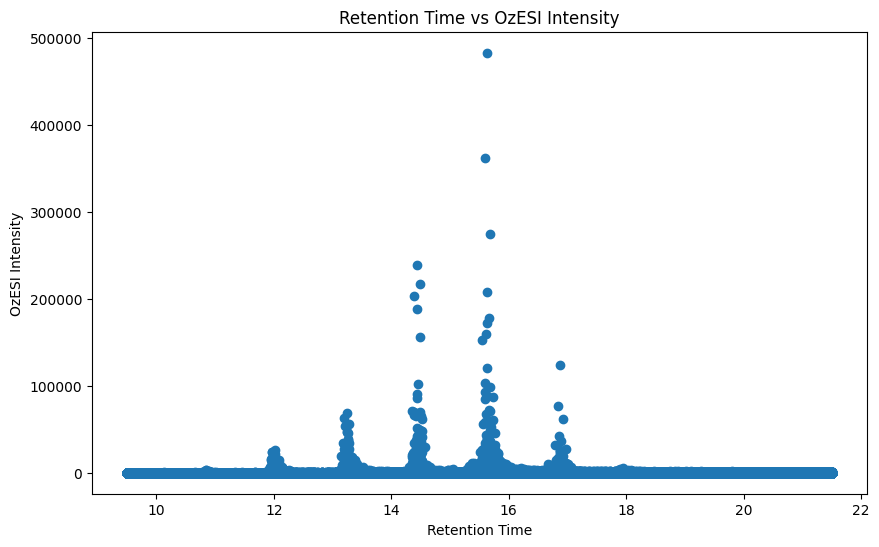

In [13]:


# Assuming clustered_data is your DataFrame with the necessary data

# Plotting the Intensity vs Retention Time
plt.figure(figsize=(10, 6))
plt.scatter(d1a['Retention_Time'], d1a['OzESI_Intensity'])

# Adding labels and title to the plot
plt.xlabel('Retention Time')
plt.ylabel('OzESI Intensity')
plt.title('Retention Time vs OzESI Intensity')

# Displaying the plot
plt.show()


# Pipeline for OzON Truth

# d1a to d1b take raw dataframe and Match Lipids

In [14]:
d1b = d1a.copy()

# Assuming df_MRM and d1b are already defined

# Create Match_Group in d1a if it doesn't exist
if 'Match_Group' not in d1a.columns:
    d1a['Match_Group'] = d1a.groupby(['Parent_Ion', 'Product_Ion', 'Sample_ID']).ngroup()

# Copy Match_Group to d1b
d1b['Match_Group'] = d1a['Match_Group']

# Function to check if two ions are within the tolerance
def is_within_tolerance(ion1, ion2, tolerance=0.3):
    return abs(ion1 - ion2) <= tolerance

# Add a new column for Lipid in d1b
d1b['Lipid'] = None

# Iterate through each unique Match_Group in d1a
for group in d1a['Match_Group'].unique():
    # Extract a representative row for the current group from d1a
    group_row = d1a[d1a['Match_Group'] == group].iloc[0]

    # Find a matching lipid in df_MRM for the representative row
    for _, mrm_row in df_MRM.iterrows():
        if is_within_tolerance(group_row['Parent_Ion'], mrm_row['Parent_Ion']) and is_within_tolerance(group_row['Product_Ion'], mrm_row['Product_Ion']):
            # Assign the lipid to all rows in the corresponding group in d1b
            d1b.loc[d1b['Match_Group'] == group, 'Lipid'] = mrm_row['Lipid']
            break  # Stop searching once a match is found

# Display the updated d1b DataFrame
d1b

,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,Match_Group,Lipid
213,584.4,437.3,9.502817,42.600002,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3,0,NaN
214,584.4,437.3,9.547217,42.580002,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3,0,NaN
215,584.4,437.3,9.591617,42.560001,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3,0,NaN
216,584.4,437.3,9.636033,42.820004,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3,0,NaN
217,584.4,437.3,9.680433,42.560001,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3,0,NaN
...,...,...,...,...,...,...,...,...
1688506,956.9,657.6,21.315367,41.960003,11282023_FAD189_M3_WT_hippo_O3on_01,956.9 -> 657.6,2879,"[TG(59:11),TG(58:4)]_FA18:1"
1688507,956.9,657.6,21.359767,42.040005,11282023_FAD189_M3_WT_hippo_O3on_01,956.9 -> 657.6,2879,"[TG(59:11),TG(58:4)]_FA18:1"
1688508,956.9,657.6,21.404183,42.000004,11282023_FAD189_M3_WT_hippo_O3on_01,956.9 -> 657.6,2879,"[TG(59:11),TG(58:4)]_FA18:1"
1688509,956.9,657.6,21.448583,42.120003,11282023_FAD189_M3_WT_hippo_O3on_01,956.9 -> 657.6,2879,"[TG(59:11),TG(58:4)]_FA18:1"


# Assign Correct_RT for each Lipid group is OzON to define ground truth RT for each lipid in each sample

In [15]:

def extract_details_from_sample_id(df, column_name='Sample_ID'):
    """
    Extracts details from the Sample_ID column and adds them as new columns: Cage, Mouse, Genotype, and Biology.

    Args:
    df (pandas.DataFrame): The DataFrame containing the Sample_ID column.
    column_name (str): The name of the column to extract the details from. Default is 'Sample_ID'.

    Returns:
    pandas.DataFrame: The original DataFrame with added columns 'Cage', 'Mouse', 'Genotype', 'Biology'.
    """
    # Regular expression pattern to extract Cage, Mouse, Genotype, and Biology
    pattern = r'^[^_]*_(?P<Cage>[^_]+)_(?P<Mouse>[^_]+)_(?P<Genotype>[^_]+)_(?P<Biology>[^_]+)'

    # Extract the matched patterns and create the new columns
    df_extracted = df[column_name].str.extract(pattern)

    # Add the new columns to the original DataFrame
    df = pd.concat([df, df_extracted[['Cage', 'Mouse', 'Genotype', 'Biology']]], axis=1)

    return df

# Usage Example:
# Assuming your DataFrame is named df
d1c = extract_details_from_sample_id(d1b)
d1c


,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,Match_Group,Lipid,Cage,Mouse,Genotype,Biology
213,584.4,437.3,9.502817,42.600002,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD94,F3,WT,cereb
214,584.4,437.3,9.547217,42.580002,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD94,F3,WT,cereb
215,584.4,437.3,9.591617,42.560001,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD94,F3,WT,cereb
216,584.4,437.3,9.636033,42.820004,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD94,F3,WT,cereb
217,584.4,437.3,9.680433,42.560001,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD94,F3,WT,cereb
...,...,...,...,...,...,...,...,...,...,...,...,...
1688506,956.9,657.6,21.315367,41.960003,11282023_FAD189_M3_WT_hippo_O3on_01,956.9 -> 657.6,2879,"[TG(59:11),TG(58:4)]_FA18:1",FAD189,M3,WT,hippo
1688507,956.9,657.6,21.359767,42.040005,11282023_FAD189_M3_WT_hippo_O3on_01,956.9 -> 657.6,2879,"[TG(59:11),TG(58:4)]_FA18:1",FAD189,M3,WT,hippo
1688508,956.9,657.6,21.404183,42.000004,11282023_FAD189_M3_WT_hippo_O3on_01,956.9 -> 657.6,2879,"[TG(59:11),TG(58:4)]_FA18:1",FAD189,M3,WT,hippo
1688509,956.9,657.6,21.448583,42.120003,11282023_FAD189_M3_WT_hippo_O3on_01,956.9 -> 657.6,2879,"[TG(59:11),TG(58:4)]_FA18:1",FAD189,M3,WT,hippo


# Create group based off mouse cage genotype


In [16]:
import pandas as pd

def add_group_sample_column(df):
    """
    Adds a new column 'Group_Sample' to the DataFrame, assigning a unique group number 
    for each combination of Cage, Mouse, Genotype, Biology, and Lipid.

    Args:
    df (pandas.DataFrame): The DataFrame to process.

    Returns:
    pandas.DataFrame: The DataFrame with the added 'Group_Sample' column.
    """
    # Create the 'Group_Sample' column by assigning a group number for each combination
    df['Group_Sample'] = df.groupby(['Cage', 'Mouse', 'Genotype', 'Biology', 'Lipid']).ngroup()

    return df

# Usage Example:
# Assuming your DataFrame is named df
d1d = add_group_sample_column(d1c)
d1d


,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,Match_Group,Lipid,Cage,Mouse,Genotype,Biology,Group_Sample
213,584.4,437.3,9.502817,42.600002,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD94,F3,WT,cereb,-1
214,584.4,437.3,9.547217,42.580002,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD94,F3,WT,cereb,-1
215,584.4,437.3,9.591617,42.560001,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD94,F3,WT,cereb,-1
216,584.4,437.3,9.636033,42.820004,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD94,F3,WT,cereb,-1
217,584.4,437.3,9.680433,42.560001,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD94,F3,WT,cereb,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1688506,956.9,657.6,21.315367,41.960003,11282023_FAD189_M3_WT_hippo_O3on_01,956.9 -> 657.6,2879,"[TG(59:11),TG(58:4)]_FA18:1",FAD189,M3,WT,hippo,597
1688507,956.9,657.6,21.359767,42.040005,11282023_FAD189_M3_WT_hippo_O3on_01,956.9 -> 657.6,2879,"[TG(59:11),TG(58:4)]_FA18:1",FAD189,M3,WT,hippo,597
1688508,956.9,657.6,21.404183,42.000004,11282023_FAD189_M3_WT_hippo_O3on_01,956.9 -> 657.6,2879,"[TG(59:11),TG(58:4)]_FA18:1",FAD189,M3,WT,hippo,597
1688509,956.9,657.6,21.448583,42.120003,11282023_FAD189_M3_WT_hippo_O3on_01,956.9 -> 657.6,2879,"[TG(59:11),TG(58:4)]_FA18:1",FAD189,M3,WT,hippo,597


# df_db_pos codeblock to make OzON n-# reference

In [173]:
import pandas as pd
import re

# 1. Reading Data
OzON_Correct_RT = pd.read_csv('Projects/FaceFats/data/OzON_CorrectRT/FF_BrainWT_OzON_CorrectRT.csv')
df_MRM_RT_correct = OzON_Correct_RT.copy()

# # 2. Filter for '54:1' in df_MRM_RT_correct
# tg_54_1_rows = df_MRM_RT_correct[df_MRM_RT_correct['Lipid'].str.contains('54:1')]
# print(tg_54_1_rows)

# 3. Initialize df_DB_aldehyde
df_DB_aldehyde = pd.DataFrame(columns=['DB_Position', 'Aldehyde_Ion'])
for position in range(3, 21):
    df_DB_aldehyde.loc[position, 'DB_Position'] = position
    df_DB_aldehyde.loc[position, 'Aldehyde_Ion'] = 26 + (14 * (position - 3))

## COPY df_MRM_RT_correct to df_db_pos ## 
df_db_pos = df_MRM_RT_correct.copy()
# 3. Add n-# columns to df_MRM_RT_correct
db_pos_list = [7, 9, 10, 12]
for number in db_pos_list:
    df_db_pos[f'n-{number}'] = pd.NA  # Initialize the new columns with NA

# 4. Calculate the n-# values
for ozesi_position in db_pos_list:
    aldehyde_ion = df_DB_aldehyde.loc[df_DB_aldehyde["DB_Position"] == ozesi_position, "Aldehyde_Ion"].values[0]
    df_db_pos[f"n-{ozesi_position}"] = df_db_pos["Parent_Ion"] - aldehyde_ion


# 6. Further Processing on df_db_pos
# Calculate 'n-i' values
for ozesi_position in db_pos_list:
    aldehyde_ion = df_DB_aldehyde.loc[df_DB_aldehyde["DB_Position"] == ozesi_position, "Aldehyde_Ion"].values[0]
    df_db_pos[f"n-{ozesi_position}"] = df_db_pos["Parent_Ion"] - aldehyde_ion

# Determine 'FAC'
def determine_fac(lipid):
    if 'FA18:1' in lipid:
        return 'FA18:1'
    elif 'FA16:1' in lipid:
        return 'FA16:1'
    else:
        return None
df_db_pos['FAC'] = df_db_pos['Lipid'].apply(determine_fac)

# Extract and sort 'TG' values
def extract_tg(lipid):
    pattern = r'TG\(\d+:\d+\)'
    matches = re.findall(pattern, lipid)
    return ', '.join(matches) if matches else None

def sort_tg_values(tg_cell):
    if not pd.isna(tg_cell) and ', ' in tg_cell:
        tg_list = tg_cell.split(', ')
        tg_list_sorted = sorted(tg_list, key=lambda x: [int(i) for i in x[3:-1].split(':')])
        return ', '.join(tg_list_sorted)
    else:
        return tg_cell
    
def remove_tg_zero(lipid):
    pattern = r'TG\(\d+:0\)'
    new_lipid = re.sub(pattern, '', lipid)
    new_lipid = re.sub(r',\s+', ', ', new_lipid).strip(', ')
    return new_lipid

# Apply extract_tg to create the TG column
df_db_pos['TG'] = df_db_pos['Lipid'].apply(extract_tg)

# Clean up the Lipid column
df_db_pos['Lipid'] = df_db_pos['Lipid'].apply(remove_tg_zero)

# Apply sort_tg_values to sort TG values within each cell
df_db_pos['TG'] = df_db_pos['TG'].apply(sort_tg_values)

# df_db_pos.to_excel(db_save_directory + 'FaceFats_Brain5xFAD_OzON.xlsx')
#reset index
df_db_pos.reset_index(drop=True, inplace=True)
#drop columns Unnamed: 0, New_ID, Match_Group and Group_Sample
df_db_pos.drop(columns=['Unnamed: 0', 'New_ID', 'Match_Group', 'Group_Sample'], inplace=True)

# Display the final DataFrame
df_db_pos



,Biology,Cage,Correct_RT,Genotype,Lipid,Mouse,OzESI_Intensity,Parent_Ion,Product_Ion,Retention_Time,Sample_ID,Transition,n-7,n-9,n-10,n-12,FAC,TG
0,cereb,DOD94,13.29,WT,[TG(50:3)]_FA18:1,F3,1096.040039,846.8,547.5,13.29,11282023_DOD94_F3_WT_cereb_O3on_01,846.8 -> 547.5,764.8,736.8,722.8,694.8,FA18:1,TG(50:3)
1,cortex,DOD94,13.33,WT,[TG(50:3)]_FA18:1,F3,1995.400146,846.8,547.5,13.33,11282023_DOD94_F3_WT_cortex_O3on_01,846.8 -> 547.5,764.8,736.8,722.8,694.8,FA18:1,TG(50:3)
2,hippo,DOD94,13.38,WT,[TG(50:3)]_FA18:1,F3,641.280029,846.8,547.5,13.38,11282023_DOD94_F3_WT_hippo_O3on_01,846.8 -> 547.5,764.8,736.8,722.8,694.8,FA18:1,TG(50:3)
3,cereb,FAD184,13.20,WT,[TG(50:3)]_FA18:1,F3,757.400024,846.8,547.5,13.20,11282023_FAD184_F3_WT_cereb_O3on_01,846.8 -> 547.5,764.8,736.8,722.8,694.8,FA18:1,TG(50:3)
4,cortex,FAD184,13.33,WT,[TG(50:3)]_FA18:1,F3,7581.460449,846.8,547.5,13.33,11282023_FAD184_F3_WT_cortex_O3on_01,846.8 -> 547.5,764.8,736.8,722.8,694.8,FA18:1,TG(50:3)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,cortex,FAD184,14.35,WT,"[TG(57:12),TG(56:5)]_FA18:1",F3,604.340027,926.8,627.5,14.35,11282023_FAD184_F3_WT_cortex_O3on_01,926.8 -> 627.5,844.8,816.8,802.8,774.8,FA18:1,"TG(56:5), TG(57:12)"
114,cortex,FAD185,14.48,WT,"[TG(57:12),TG(56:5)]_FA18:1",M4,718.180054,926.8,627.5,14.48,11282023_FAD185_M4_WT_cortex_O3on_01,926.8 -> 627.5,844.8,816.8,802.8,774.8,FA18:1,"TG(56:5), TG(57:12)"
115,cortex,DOD94,17.94,WT,"[TG(57:9),TG(56:2)]_FA18:1",F3,1123.800049,932.9,633.6,17.94,11282023_DOD94_F3_WT_cortex_O3on_01,932.9 -> 633.6,850.9,822.9,808.9,780.9,FA18:1,"TG(56:2), TG(57:9)"
116,cereb,FAD184,17.94,WT,"[TG(57:9),TG(56:2)]_FA18:1",F3,838.000061,932.9,633.6,17.94,11282023_FAD184_F3_WT_cereb_O3on_01,932.9 -> 633.6,850.9,822.9,808.9,780.9,FA18:1,"TG(56:2), TG(57:9)"


# quick check to make sure data is correct

In [174]:
# d1c

# # ion_tolerance = 0.3

# # # Define the window variable for retention time
# # retention_time_window = 0.25

# # # Define the target values for Parent_Ion, Product_Ion, and Retention_Time
# # target_parent_ion = 792.8
# # target_product_ion = 603.5
# # target_retention_time = 15.8

# # # Filter the DataFrame for specified ions within tolerance and retention time within the window
# # filtered_rows = d1c[
# #     (d1c['Parent_Ion'] >= target_parent_ion - ion_tolerance) & 
# #     (d1c['Parent_Ion'] <= target_parent_ion + ion_tolerance) &
# #     (d1c['Product_Ion'] >= target_product_ion - ion_tolerance) & 
# #     (d1c['Product_Ion'] <= target_product_ion + ion_tolerance) &
# #     (d1c['Retention_Time'] >= target_retention_time - retention_time_window) & 
# #     (d1c['Retention_Time'] <= target_retention_time + retention_time_window)
# # ]

# # filtered_rows

# #drop columns group_sample and Match_Group
# d1d.drop(columns=['Group_Sample'], inplace=True)
d1d


,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,Match_Group,Lipid,Cage,Mouse,Genotype,Biology,Group_Sample
213,584.4,437.3,9.502817,42.600002,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD94,F3,WT,cereb,-1
214,584.4,437.3,9.547217,42.580002,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD94,F3,WT,cereb,-1
215,584.4,437.3,9.591617,42.560001,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD94,F3,WT,cereb,-1
216,584.4,437.3,9.636033,42.820004,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD94,F3,WT,cereb,-1
217,584.4,437.3,9.680433,42.560001,11282023_DOD94_F3_WT_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD94,F3,WT,cereb,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1688506,956.9,657.6,21.315367,41.960003,11282023_FAD189_M3_WT_hippo_O3on_01,956.9 -> 657.6,2879,"[TG(59:11),TG(58:4)]_FA18:1",FAD189,M3,WT,hippo,597
1688507,956.9,657.6,21.359767,42.040005,11282023_FAD189_M3_WT_hippo_O3on_01,956.9 -> 657.6,2879,"[TG(59:11),TG(58:4)]_FA18:1",FAD189,M3,WT,hippo,597
1688508,956.9,657.6,21.404183,42.000004,11282023_FAD189_M3_WT_hippo_O3on_01,956.9 -> 657.6,2879,"[TG(59:11),TG(58:4)]_FA18:1",FAD189,M3,WT,hippo,597
1688509,956.9,657.6,21.448583,42.120003,11282023_FAD189_M3_WT_hippo_O3on_01,956.9 -> 657.6,2879,"[TG(59:11),TG(58:4)]_FA18:1",FAD189,M3,WT,hippo,597


Filter through filtered_d1 based on matched OzOFF lipids df_db_pos for n-7 and n-9 values

# NOTE TO SELF, don't filter through every data point, only filter through each group

In [175]:
import pandas as pd
from tqdm.notebook import tqdm



### original #2
tolerance = 0.3
retention_time_tolerance = 0.275  # Adjust this value as needed

# Define the columns to match
columns_to_match = ['Cage', 'Mouse', 'Genotype', 'Biology']

# Re-initializing an empty DataFrame for filtered_d2
d2 = pd.DataFrame()

# Iterating through df_db_pos
for index, row in tqdm(df_db_pos.iterrows(), total=df_db_pos.shape[0]):
    ground_truth_retention_time = row['Retention_Time']  # Ground truth retention time
    product_ion = row['Product_Ion']
    parent_ion_n7 = row['n-7']
    parent_ion_n9 = row['n-9']
    parent_ion_n10 = row['n-10']
    parent_ion_n12 = row['n-12']
    lipid_name = row['Lipid']  # Extracting Lipid name from df_db_pos

    # Defining the retention time window based on ground truth
    lower_bound_time = ground_truth_retention_time - retention_time_tolerance
    upper_bound_time = ground_truth_retention_time + retention_time_tolerance

    # Defining the tolerance for Parent and Product ions
    lower_bound_ion = product_ion - tolerance
    upper_bound_ion = product_ion + tolerance

    # Filtering d_OzON within the specified window, matching ions with tolerance, and matching additional columns
    matches = d1d[(d1d['Retention_Time'] >= lower_bound_time) & 
                     (d1d['Retention_Time'] <= upper_bound_time) &
                     (d1d['OzESI_Intensity'] >= 5) &
                     (d1d['Product_Ion'] >= lower_bound_ion) &
                     (d1d['Product_Ion'] <= upper_bound_ion) &
                     (d1d[columns_to_match].eq(row[columns_to_match])).all(axis=1)]

    # Adding 'db' and 'Lipid' columns based on the tolerance matching
    matches['db'] = ''
    matches['Lipid'] = lipid_name  # Adding the Lipid name to all matches
    matches.loc[(matches['Parent_Ion'] >= parent_ion_n7 - tolerance) & 
                (matches['Parent_Ion'] <= parent_ion_n7 + tolerance), 'db'] = 'n-7'
    matches.loc[(matches['Parent_Ion'] >= parent_ion_n9 - tolerance) & 
                (matches['Parent_Ion'] <= parent_ion_n9 + tolerance), 'db'] = 'n-9'
    matches.loc[(matches['Parent_Ion'] >= parent_ion_n10 - tolerance) & 
                (matches['Parent_Ion'] <= parent_ion_n10 + tolerance), 'db'] = 'n-10'
    matches.loc[(matches['Parent_Ion'] >= parent_ion_n12 - tolerance) & 
                (matches['Parent_Ion'] <= parent_ion_n12 + tolerance), 'db'] = 'n-12'

    # Append the matching rows to filtered_d2
    d2 = d2.append(matches)





  0%|          | 0/118 [00:00<?, ?it/s]

/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [176]:
# Resetting the index of the new DataFrame
d2 = d2.reset_index(drop=True)

# Display the first few rows of the new DataFrame
d2

,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,Match_Group,Lipid,Cage,Mouse,Genotype,Biology,Group_Sample,db
0,694.6,547.5,13.051833,42.620003,11282023_DOD94_F3_WT_cereb_O3on_01,694.6 -> 547.5,240,[TG(50:3)]_FA18:1,DOD94,F3,WT,cereb,-1,n-12
1,694.6,547.5,13.096250,42.580002,11282023_DOD94_F3_WT_cereb_O3on_01,694.6 -> 547.5,240,[TG(50:3)]_FA18:1,DOD94,F3,WT,cereb,-1,n-12
2,694.6,547.5,13.140650,42.440002,11282023_DOD94_F3_WT_cereb_O3on_01,694.6 -> 547.5,240,[TG(50:3)]_FA18:1,DOD94,F3,WT,cereb,-1,n-12
3,694.6,547.5,13.185050,42.500004,11282023_DOD94_F3_WT_cereb_O3on_01,694.6 -> 547.5,240,[TG(50:3)]_FA18:1,DOD94,F3,WT,cereb,-1,n-12
4,694.6,547.5,13.229467,42.480003,11282023_DOD94_F3_WT_cereb_O3on_01,694.6 -> 547.5,240,[TG(50:3)]_FA18:1,DOD94,F3,WT,cereb,-1,n-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8634,932.9,633.6,18.030500,59.580006,11282023_FAD184_F3_WT_cortex_O3on_01,932.9 -> 633.6,2785,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,WT,cortex,175,
8635,932.9,633.6,18.074900,84.320007,11282023_FAD184_F3_WT_cortex_O3on_01,932.9 -> 633.6,2785,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,WT,cortex,175,
8636,932.9,633.6,18.119317,109.060005,11282023_FAD184_F3_WT_cortex_O3on_01,932.9 -> 633.6,2785,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,WT,cortex,175,
8637,932.9,633.6,18.163717,75.680008,11282023_FAD184_F3_WT_cortex_O3on_01,932.9 -> 633.6,2785,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,WT,cortex,175,


# CHeck Rt of a specific lipid

In [177]:
# # Filter the DataFrame based on the specified conditions

# # Filter the DataFrame based on the specified conditions
# filtered_df = d2[(d2['Lipid'].str.contains('TG\(54:2\)')) & (d2['db'] == 'n-10') & d2['Sample_ID'].str.contains('DOD73')]

# # Print the filtered values
# filtered_df

# Determine Groups Brain Region or Liver (Biology), Genotype, FAC and remove TGs with zero double bonds

In [178]:
# Creating filtered_d3 from filtered_d2
d3 = d2.copy()

# Dropping rows where 'db' column is blank
d3 = d3[d3['db'] != '']

# # Function to determine the value for the Biology and Genotype column
# def extract_biology(sample_id):
#     for term in ["liver", "cortex", "cereb", "hippo", "dienc"]:
#         if term in sample_id.lower():
#             return term
#     return None

# # Apply the function to the Sample_ID column to create the Biology and Genotype column
# d3['Biology'] = d3['Sample_ID'].apply(extract_biology)
# d3['Genotype'] = d3['Sample_ID'].apply(lambda x: '5xFAD' if 'WT' not in x else 'WT')
d3

# # Function to remove the first TG if there are two TGs
# def remove_first_tg(lipid):
#     tg_parts = lipid.split(',')
#     if len(tg_parts) > 1:
#         return '[' + tg_parts[1]
#     else:
#         return lipid
    
# Function to determine the value for the FAC column
def determine_fac(lipid):
    if 'FA18:1' in lipid:
        return 'FA18:1'
    elif 'FA16:1' in lipid:
        return 'FA16:1'
    else:
        return None  # or some other default value

# Apply the function to the Lipid column to create the FAC column
d3['FAC'] = d3['Lipid'].apply(determine_fac)



# Function to extract TG values
def extract_tg(lipid):
    # Regular expression pattern to match TG(##:#) or similar patterns
    pattern = r'TG\(\d+:\d+\)'
    matches = re.findall(pattern, lipid)
    return ', '.join(matches) if matches else None

# Apply the function to the Lipid column to create the TG column
d3['TG'] = d3['Lipid'].apply(extract_tg)




# Function to sort TG values within a cell
def sort_tg_values(tg_cell):
    if not pd.isna(tg_cell) and ', ' in tg_cell:
        tg_list = tg_cell.split(', ')
        tg_list_sorted = sorted(tg_list, key=lambda x: [int(i) for i in x[3:-1].split(':')])
        return ', '.join(tg_list_sorted)
    else:
        return tg_cell

# Function to remove TG(##:0) patterns from the Lipid string
def remove_tg_zero(lipid):
    # Pattern to match TG(##:0)
    pattern = r'TG\(\d+:0\)'
    # Remove TG(##:0) patterns
    new_lipid = re.sub(pattern, '', lipid)
    # Remove any extra commas and spaces left after removal
    new_lipid = re.sub(r',\s+', ', ', new_lipid).strip(', ')
    return new_lipid


d3['Lipid'] = d3['Lipid'].apply(remove_tg_zero)
# Apply the function to the TG column
d3['TG'] = d3['TG'].apply(sort_tg_values)
d3 = d3.sort_values(by=['FAC', 'TG'])



# Sorting by 'Biology and Genotype' and then by 'Lipid'
d3 = d3.sort_values(by=['Biology','Genotype', 'Lipid'])

grouped_cluster_data = d3.groupby(['Lipid','db','Biology','Genotype','Sample_ID'])
#add group number to each to a new column called Group
d3['Group'] = grouped_cluster_data.ngroup()
d3


d3
#print group with highest max intensity


,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,Match_Group,Lipid,Cage,Mouse,Genotype,Biology,Group_Sample,db,FAC,TG,Group
0,694.6,547.5,13.051833,42.620003,11282023_DOD94_F3_WT_cereb_O3on_01,694.6 -> 547.5,240,[TG(50:3)]_FA18:1,DOD94,F3,WT,cereb,-1,n-12,FA18:1,TG(50:3),9
1,694.6,547.5,13.096250,42.580002,11282023_DOD94_F3_WT_cereb_O3on_01,694.6 -> 547.5,240,[TG(50:3)]_FA18:1,DOD94,F3,WT,cereb,-1,n-12,FA18:1,TG(50:3),9
2,694.6,547.5,13.140650,42.440002,11282023_DOD94_F3_WT_cereb_O3on_01,694.6 -> 547.5,240,[TG(50:3)]_FA18:1,DOD94,F3,WT,cereb,-1,n-12,FA18:1,TG(50:3),9
3,694.6,547.5,13.185050,42.500004,11282023_DOD94_F3_WT_cereb_O3on_01,694.6 -> 547.5,240,[TG(50:3)]_FA18:1,DOD94,F3,WT,cereb,-1,n-12,FA18:1,TG(50:3),9
4,694.6,547.5,13.229467,42.480003,11282023_DOD94_F3_WT_cereb_O3on_01,694.6 -> 547.5,240,[TG(50:3)]_FA18:1,DOD94,F3,WT,cereb,-1,n-12,FA18:1,TG(50:3),9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7272,822.7,605.5,16.978767,41.860004,11282023_FAD189_M3_WT_hippo_O3on_01,822.7 -> 605.5,1879,"[TG(55:9),TG(54:2)]_FA18:1",FAD189,M3,WT,hippo,-1,n-7,FA18:1,"TG(54:2), TG(55:9)",379
7273,822.7,605.5,17.023167,41.960003,11282023_FAD189_M3_WT_hippo_O3on_01,822.7 -> 605.5,1879,"[TG(55:9),TG(54:2)]_FA18:1",FAD189,M3,WT,hippo,-1,n-7,FA18:1,"TG(54:2), TG(55:9)",379
7274,822.7,605.5,17.067567,41.860004,11282023_FAD189_M3_WT_hippo_O3on_01,822.7 -> 605.5,1879,"[TG(55:9),TG(54:2)]_FA18:1",FAD189,M3,WT,hippo,-1,n-7,FA18:1,"TG(54:2), TG(55:9)",379
7275,822.7,605.5,17.111983,41.760002,11282023_FAD189_M3_WT_hippo_O3on_01,822.7 -> 605.5,1879,"[TG(55:9),TG(54:2)]_FA18:1",FAD189,M3,WT,hippo,-1,n-7,FA18:1,"TG(54:2), TG(55:9)",379


# GMM

In [179]:
import pandas as pd
from sklearn.mixture import GaussianMixture

# Assuming d3 is your DataFrame
d4 = pd.DataFrame()  # Initialize an empty DataFrame to store clustered results

# Iterate over each group in the 'Group' column
for group_id, group in tqdm(d3.groupby(['Group']), desc="Clustering Groups"):
    # Calculate 1% below the maximum 'OzESI_Intensity'
    max_intensity = group['OzESI_Intensity'].max()
    cutoff_intensity = max_intensity * 0.00005

    # Apply the filters
    filtered_group = group[(group['OzESI_Intensity'] >= cutoff_intensity) & (group['OzESI_Intensity'] > 0)]

    # Check if the filtered group is empty or has less than 2 samples
    if filtered_group.empty or len(filtered_group) < 2:
        continue

    # Reshape the 'Retention_Time' data for GMM
    retention_times = filtered_group[['Retention_Time']].values

    # Apply GMM clustering to this specific group
    # Note: Adjust the number of components (n_components) as needed
    gmm = GaussianMixture(n_components=1, covariance_type='full').fit(retention_times)

    # Get the cluster labels
    labels = gmm.predict(retention_times)

    # Add the cluster labels to the filtered group
    filtered_group['Cluster_Label'] = labels

    # Append the clustered group to the results DataFrame
    d4 = pd.concat([d4, filtered_group])

# The resulting DataFrame, d4, now contains separately clustered data for each group


Clustering Groups:   0%|          | 0/472 [00:00<?, ?it/s]

## Check GMM Clusters

In [180]:
# Filter the DataFrame based on the specified conditions
d5 = d4.copy()

# Filter the DataFrame based on the specified conditions
filtered_df = d5[(d5['Lipid'].str.contains('TG\(50:3\)')) & (d5['db'] == 'n-9') & d5['Sample_ID'].str.contains('DOD73')]

# Print the filtered values
filtered_df
d5
# d5

,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,Match_Group,Lipid,Cage,Mouse,Genotype,Biology,Group_Sample,db,FAC,TG,Group,Cluster_Label
12,722.7,547.5,13.050350,42.520004,11282023_DOD94_F3_WT_cereb_O3on_01,722.7 -> 547.5,340,[TG(50:3)]_FA18:1,DOD94,F3,WT,cereb,-1,n-10,FA18:1,TG(50:3),0,0
13,722.7,547.5,13.094750,42.660004,11282023_DOD94_F3_WT_cereb_O3on_01,722.7 -> 547.5,340,[TG(50:3)]_FA18:1,DOD94,F3,WT,cereb,-1,n-10,FA18:1,TG(50:3),0,0
14,722.7,547.5,13.139167,42.580002,11282023_DOD94_F3_WT_cereb_O3on_01,722.7 -> 547.5,340,[TG(50:3)]_FA18:1,DOD94,F3,WT,cereb,-1,n-10,FA18:1,TG(50:3),0,0
15,722.7,547.5,13.183567,42.640003,11282023_DOD94_F3_WT_cereb_O3on_01,722.7 -> 547.5,340,[TG(50:3)]_FA18:1,DOD94,F3,WT,cereb,-1,n-10,FA18:1,TG(50:3),0,0
16,722.7,547.5,13.227967,42.500004,11282023_DOD94_F3_WT_cereb_O3on_01,722.7 -> 547.5,340,[TG(50:3)]_FA18:1,DOD94,F3,WT,cereb,-1,n-10,FA18:1,TG(50:3),0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8609,822.8,633.6,17.999850,252.960022,11282023_FAD184_F3_WT_cortex_O3on_01,822.8 -> 633.6,1885,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,WT,cortex,-1,n-9,FA18:1,"TG(56:2), TG(57:9)",471,0
8610,822.8,633.6,18.044250,42.100002,11282023_FAD184_F3_WT_cortex_O3on_01,822.8 -> 633.6,1885,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,WT,cortex,-1,n-9,FA18:1,"TG(56:2), TG(57:9)",471,0
8611,822.8,633.6,18.088650,42.040005,11282023_FAD184_F3_WT_cortex_O3on_01,822.8 -> 633.6,1885,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,WT,cortex,-1,n-9,FA18:1,"TG(56:2), TG(57:9)",471,0
8612,822.8,633.6,18.133067,42.020004,11282023_FAD184_F3_WT_cortex_O3on_01,822.8 -> 633.6,1885,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,WT,cortex,-1,n-9,FA18:1,"TG(56:2), TG(57:9)",471,0


# Single GMM

In [181]:
# Assuming d3 is your DataFrame
d_single = pd.DataFrame()  # Initialize an empty DataFrame to store the result for a single group

# Specify the group to perform GMM on
specified_group = 60  # Replace 'Your_Group_ID' with the desired group identifier

# Check if the specified group exists in d3
if specified_group in d3['Group'].unique():
    # Filter the DataFrame for the specified group
    group = d3[d3['Group'] == specified_group]

    # Calculate 1% below the maximum 'OzESI_Intensity'
    max_intensity = group['OzESI_Intensity'].max()
    cutoff_intensity = max_intensity * 0.00005

    # Apply the filters
    filtered_group = group[(group['OzESI_Intensity'] >= cutoff_intensity) & (group['OzESI_Intensity'] > 0)]

    # Proceed only if the filtered group is not empty and has more than 1 sample
    if not filtered_group.empty and len(filtered_group) >= 2:
        # Reshape the 'Retention_Time' data for GMM
        retention_times = filtered_group[['Retention_Time']].values

        # Apply GMM clustering to this specific group
        # Note: Adjust the number of components (n_components) as needed
        gmm = GaussianMixture(n_components=3, covariance_type='full').fit(retention_times)

        # Get the cluster labels
        labels = gmm.predict(retention_times)

        # Add the cluster labels to the filtered group
        filtered_group['Cluster_Label'] = labels

        # Save the clustered group to d_single DataFrame
        d_single = filtered_group

else:
    print(f"Group '{specified_group}' not found in the DataFrame.")

# The resulting DataFrame, d_single, now contains clustered data for the specified group


# Plot GMM CLuster Check for specific lipid

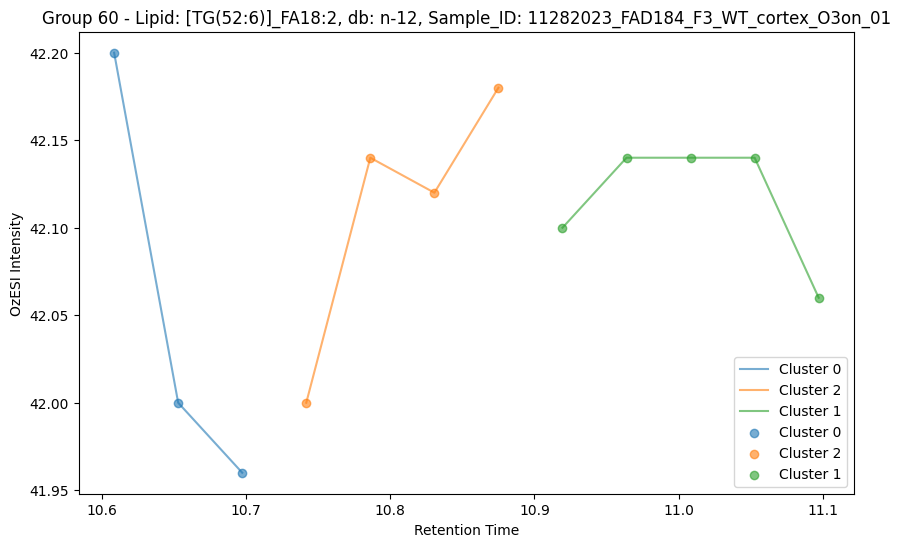

In [182]:
import matplotlib.pyplot as plt


# Plotting the filtered data with colors based on Cluster_Label
plt.figure(figsize=(10, 6))

# Extracting Lipid, db, and Sample_ID for the title (assuming they are consistent within the group)
lipid = d_single['Lipid'].iloc[0] if not d_single.empty else 'N/A'
db = d_single['db'].iloc[0] if not d_single.empty else 'N/A'
sample_id = d_single['Sample_ID'].iloc[0] if not d_single.empty else 'N/A'

# Iterate through each unique value in the Cluster_Label column
for label in d_single['Cluster_Label'].unique():
    # Filter the DataFrame for each label
    cluster_df = d_single[d_single['Cluster_Label'] == label]
    
    # Plot each cluster with a different color
    plt.scatter(cluster_df['Retention_Time'], cluster_df['OzESI_Intensity'], alpha=0.6, label=f'Cluster {label}')
    plt.plot(cluster_df['Retention_Time'], cluster_df['OzESI_Intensity'], alpha=0.6, label=f'Cluster {label}')
plt.xlabel('Retention Time')
plt.ylabel('OzESI Intensity')
plt.title(f'Group {specified_group} - Lipid: {lipid}, db: {db}, Sample_ID: {sample_id}')
plt.legend()
plt.show()


# Plot whole spectrum to make sure data is correct

In [183]:
# # Assuming clustered_data is your DataFrame with the necessary data

# # Plotting the Intensity vs Retention Time
# plt.figure(figsize=(10, 6))
# plt.scatter(d4['Retention_Time'], d4['OzESI_Intensity'])

# # Adding labels and title to the plot
# plt.xlabel('Retention Time')
# plt.ylabel('OzESI Intensity')
# plt.title('Retention Time vs OzESI Intensity')

# # Displaying the plot
# plt.show()


# Save GMM Results

In [184]:
save_gmm_results_directory = 'Projects/FaceFats/results/GMM_results/'
save_gmm_results_name = 'FF_BrainWT_OzON_Truth_GMM_results_14Jan24.csv'
# d5.to_csv(save_gmm_results_directory + save_gmm_results_name)
def save_csv_with_increment(df, directory, filename):
    # Check if the directory exists, if not, create it
    if not os.path.exists(directory):
        os.makedirs(directory)
    base, extension = os.path.splitext(filename)
    counter = 1
    new_filename = filename

    # Check if file exists and increment the counter until an unused filename is found
    while os.path.isfile(os.path.join(directory, new_filename)):
        new_filename = f"{base}_{counter}{extension}"
        counter += 1

    # Save the dataframe to the new path
    df.to_csv(os.path.join(directory, new_filename), index=False)
    print(f"File saved as: {new_filename}")

# Example usage
save_csv_with_increment(d5, save_gmm_results_directory, save_gmm_results_name)

File saved as: FF_BrainWT_OzON_Truth_GMM_results_14Jan24_3.csv


In [257]:
d5
d5[d5['Group'] == 265]

,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,Match_Group,Lipid,Cage,Mouse,Genotype,Biology,Group_Sample,db,FAC,TG,Group,Cluster_Label
4638,818.7,601.5,14.226683,42.720001,11282023_DOD94_F3_WT_cortex_O3on_01,818.7 -> 601.5,1781,"[TG(55:11),TG(54:4)]_FA18:1",DOD94,F3,WT,cortex,-1,n-7,FA18:1,"TG(54:4), TG(55:11)",265,0
4639,818.7,601.5,14.271100,42.760002,11282023_DOD94_F3_WT_cortex_O3on_01,818.7 -> 601.5,1781,"[TG(55:11),TG(54:4)]_FA18:1",DOD94,F3,WT,cortex,-1,n-7,FA18:1,"TG(54:4), TG(55:11)",265,0
4640,818.7,601.5,14.315500,42.920002,11282023_DOD94_F3_WT_cortex_O3on_01,818.7 -> 601.5,1781,"[TG(55:11),TG(54:4)]_FA18:1",DOD94,F3,WT,cortex,-1,n-7,FA18:1,"TG(54:4), TG(55:11)",265,0
4641,818.7,601.5,14.359900,42.780003,11282023_DOD94_F3_WT_cortex_O3on_01,818.7 -> 601.5,1781,"[TG(55:11),TG(54:4)]_FA18:1",DOD94,F3,WT,cortex,-1,n-7,FA18:1,"TG(54:4), TG(55:11)",265,0
4642,818.7,601.5,14.404317,42.920002,11282023_DOD94_F3_WT_cortex_O3on_01,818.7 -> 601.5,1781,"[TG(55:11),TG(54:4)]_FA18:1",DOD94,F3,WT,cortex,-1,n-7,FA18:1,"TG(54:4), TG(55:11)",265,0
4643,818.7,601.5,14.448717,43.060001,11282023_DOD94_F3_WT_cortex_O3on_01,818.7 -> 601.5,1781,"[TG(55:11),TG(54:4)]_FA18:1",DOD94,F3,WT,cortex,-1,n-7,FA18:1,"TG(54:4), TG(55:11)",265,0
4644,818.7,601.5,14.493133,42.960003,11282023_DOD94_F3_WT_cortex_O3on_01,818.7 -> 601.5,1781,"[TG(55:11),TG(54:4)]_FA18:1",DOD94,F3,WT,cortex,-1,n-7,FA18:1,"TG(54:4), TG(55:11)",265,0
4645,818.7,601.5,14.537533,42.900002,11282023_DOD94_F3_WT_cortex_O3on_01,818.7 -> 601.5,1781,"[TG(55:11),TG(54:4)]_FA18:1",DOD94,F3,WT,cortex,-1,n-7,FA18:1,"TG(54:4), TG(55:11)",265,0
4646,818.7,601.5,14.581933,42.860004,11282023_DOD94_F3_WT_cortex_O3on_01,818.7 -> 601.5,1781,"[TG(55:11),TG(54:4)]_FA18:1",DOD94,F3,WT,cortex,-1,n-7,FA18:1,"TG(54:4), TG(55:11)",265,0
4647,818.7,601.5,14.626350,42.880005,11282023_DOD94_F3_WT_cortex_O3on_01,818.7 -> 601.5,1781,"[TG(55:11),TG(54:4)]_FA18:1",DOD94,F3,WT,cortex,-1,n-7,FA18:1,"TG(54:4), TG(55:11)",265,0


# Make MaxI column so we can filter based off that later

In [260]:
d6 = d5.copy()
d6

import pandas as pd

def Make_MaxI(df):
    """
    Creates a 'Max_Intensity' column in the DataFrame, containing the maximum OzESI_Intensity
    for each group based on Mouse, Genotype, Biology, db, Lipid, and FAC.

    Args:
        df (pandas.DataFrame): The DataFrame to process.

    Returns:
        pandas.DataFrame: The DataFrame with the new Max_Intensity column.
    """
    # Grouping the DataFrame by specified columns and finding the max intensity for each group
    max_intensity_per_group = df.groupby(['Mouse', 'Genotype', 'Biology', 'db', 'Lipid', 'FAC','Group'])['OzESI_Intensity'].transform('max').round(0)

    # Assigning the max intensity to the Max_Intensity column
    df['Max_Intensity'] = max_intensity_per_group

    return df

d6a = Make_MaxI(d6)
d6a



,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,Match_Group,Lipid,Cage,Mouse,Genotype,Biology,Group_Sample,db,FAC,TG,Group,Cluster_Label,Max_Intensity
12,722.7,547.5,13.050350,42.520004,11282023_DOD94_F3_WT_cereb_O3on_01,722.7 -> 547.5,340,[TG(50:3)]_FA18:1,DOD94,F3,WT,cereb,-1,n-10,FA18:1,TG(50:3),0,0,76.0
13,722.7,547.5,13.094750,42.660004,11282023_DOD94_F3_WT_cereb_O3on_01,722.7 -> 547.5,340,[TG(50:3)]_FA18:1,DOD94,F3,WT,cereb,-1,n-10,FA18:1,TG(50:3),0,0,76.0
14,722.7,547.5,13.139167,42.580002,11282023_DOD94_F3_WT_cereb_O3on_01,722.7 -> 547.5,340,[TG(50:3)]_FA18:1,DOD94,F3,WT,cereb,-1,n-10,FA18:1,TG(50:3),0,0,76.0
15,722.7,547.5,13.183567,42.640003,11282023_DOD94_F3_WT_cereb_O3on_01,722.7 -> 547.5,340,[TG(50:3)]_FA18:1,DOD94,F3,WT,cereb,-1,n-10,FA18:1,TG(50:3),0,0,76.0
16,722.7,547.5,13.227967,42.500004,11282023_DOD94_F3_WT_cereb_O3on_01,722.7 -> 547.5,340,[TG(50:3)]_FA18:1,DOD94,F3,WT,cereb,-1,n-10,FA18:1,TG(50:3),0,0,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8609,822.8,633.6,17.999850,252.960022,11282023_FAD184_F3_WT_cortex_O3on_01,822.8 -> 633.6,1885,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,WT,cortex,-1,n-9,FA18:1,"TG(56:2), TG(57:9)",471,0,511.0
8610,822.8,633.6,18.044250,42.100002,11282023_FAD184_F3_WT_cortex_O3on_01,822.8 -> 633.6,1885,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,WT,cortex,-1,n-9,FA18:1,"TG(56:2), TG(57:9)",471,0,511.0
8611,822.8,633.6,18.088650,42.040005,11282023_FAD184_F3_WT_cortex_O3on_01,822.8 -> 633.6,1885,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,WT,cortex,-1,n-9,FA18:1,"TG(56:2), TG(57:9)",471,0,511.0
8612,822.8,633.6,18.133067,42.020004,11282023_FAD184_F3_WT_cortex_O3on_01,822.8 -> 633.6,1885,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,WT,cortex,-1,n-9,FA18:1,"TG(56:2), TG(57:9)",471,0,511.0


In [261]:
# d6a group 261
d6a[d6a['Group'] == 265]

,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,Match_Group,Lipid,Cage,Mouse,Genotype,Biology,Group_Sample,db,FAC,TG,Group,Cluster_Label,Max_Intensity
4638,818.7,601.5,14.226683,42.720001,11282023_DOD94_F3_WT_cortex_O3on_01,818.7 -> 601.5,1781,"[TG(55:11),TG(54:4)]_FA18:1",DOD94,F3,WT,cortex,-1,n-7,FA18:1,"TG(54:4), TG(55:11)",265,0,43.0
4639,818.7,601.5,14.271100,42.760002,11282023_DOD94_F3_WT_cortex_O3on_01,818.7 -> 601.5,1781,"[TG(55:11),TG(54:4)]_FA18:1",DOD94,F3,WT,cortex,-1,n-7,FA18:1,"TG(54:4), TG(55:11)",265,0,43.0
4640,818.7,601.5,14.315500,42.920002,11282023_DOD94_F3_WT_cortex_O3on_01,818.7 -> 601.5,1781,"[TG(55:11),TG(54:4)]_FA18:1",DOD94,F3,WT,cortex,-1,n-7,FA18:1,"TG(54:4), TG(55:11)",265,0,43.0
4641,818.7,601.5,14.359900,42.780003,11282023_DOD94_F3_WT_cortex_O3on_01,818.7 -> 601.5,1781,"[TG(55:11),TG(54:4)]_FA18:1",DOD94,F3,WT,cortex,-1,n-7,FA18:1,"TG(54:4), TG(55:11)",265,0,43.0
4642,818.7,601.5,14.404317,42.920002,11282023_DOD94_F3_WT_cortex_O3on_01,818.7 -> 601.5,1781,"[TG(55:11),TG(54:4)]_FA18:1",DOD94,F3,WT,cortex,-1,n-7,FA18:1,"TG(54:4), TG(55:11)",265,0,43.0
4643,818.7,601.5,14.448717,43.060001,11282023_DOD94_F3_WT_cortex_O3on_01,818.7 -> 601.5,1781,"[TG(55:11),TG(54:4)]_FA18:1",DOD94,F3,WT,cortex,-1,n-7,FA18:1,"TG(54:4), TG(55:11)",265,0,43.0
4644,818.7,601.5,14.493133,42.960003,11282023_DOD94_F3_WT_cortex_O3on_01,818.7 -> 601.5,1781,"[TG(55:11),TG(54:4)]_FA18:1",DOD94,F3,WT,cortex,-1,n-7,FA18:1,"TG(54:4), TG(55:11)",265,0,43.0
4645,818.7,601.5,14.537533,42.900002,11282023_DOD94_F3_WT_cortex_O3on_01,818.7 -> 601.5,1781,"[TG(55:11),TG(54:4)]_FA18:1",DOD94,F3,WT,cortex,-1,n-7,FA18:1,"TG(54:4), TG(55:11)",265,0,43.0
4646,818.7,601.5,14.581933,42.860004,11282023_DOD94_F3_WT_cortex_O3on_01,818.7 -> 601.5,1781,"[TG(55:11),TG(54:4)]_FA18:1",DOD94,F3,WT,cortex,-1,n-7,FA18:1,"TG(54:4), TG(55:11)",265,0,43.0
4647,818.7,601.5,14.626350,42.880005,11282023_DOD94_F3_WT_cortex_O3on_01,818.7 -> 601.5,1781,"[TG(55:11),TG(54:4)]_FA18:1",DOD94,F3,WT,cortex,-1,n-7,FA18:1,"TG(54:4), TG(55:11)",265,0,43.0


# Obtain ground truth difference for each RT cluster by comparing the Max Intensity RT for each cluster to the ground truth. Keep cluster closest to the ground truth. 

In [262]:
d7 = d6a.copy()
df_all_clusters = d6a.copy()

# def get_ground_truth_diff(row, df_db_pos):
#     # Get the ground truth Retention_Time for the Lipid
#     ground_truth_rt = df_db_pos[df_db_pos['Lipid'] == row['Lipid']]['Retention_Time'].iloc[0]
#     # Calculate the absolute difference
#     return abs(row['Retention_Time'] - ground_truth_rt)

# d7['Ground_Truth_Dif'] = d7.apply(get_ground_truth_diff, args=(df_db_pos,), axis=1)

# Step 1: Define a function to find the peak RT for each cluster
def get_peak_rt(group_df):
    peak_rt_row = group_df.loc[group_df['OzESI_Intensity'].idxmax()]
    return peak_rt_row['Retention_Time']

# Step 2: Group by 'Group' and 'Cluster_Label' to apply the function
cluster_peak_rt = d7.groupby(['Group', 'Cluster_Label']).apply(get_peak_rt)

# Step 3: Merge the peak RT values back into d7
d7 = d7.merge(cluster_peak_rt.rename('Cluster_RT'), on=['Group', 'Cluster_Label'], how='left')

def get_cluster_rt_ground_truth_diff(row, df_db_pos):
    # Get the ground truth Retention_Time for the Lipid
    ground_truth_rt = df_db_pos[df_db_pos['Lipid'] == row['Lipid']]['Retention_Time'].iloc[0]
    # Calculate the absolute difference with Cluster_RT
    return abs(row['Cluster_RT'] - ground_truth_rt)

# Apply this function to each row of d7 to calculate the ground truth difference for Cluster_RT
d7['Cluster_Ground_Truth_Dif'] = d7.apply(get_cluster_rt_ground_truth_diff, args=(df_db_pos,), axis=1)


# Initialize an empty DataFrame to store rows with the lowest Cluster_Ground_Truth_Dif for each group
d7a = pd.DataFrame()

# Group by 'Group' and find the cluster with the lowest Cluster_Ground_Truth_Dif in each group
for group, group_df in d7.groupby('Group'):
    idx_lowest_dif = group_df['Cluster_Ground_Truth_Dif'].idxmin()
    winning_cluster = group_df.loc[idx_lowest_dif, 'Cluster_Label']
    winning_cluster_rows = group_df[group_df['Cluster_Label'] == winning_cluster]
    d7a = d7a.append(winning_cluster_rows)

def filter_groups_by_intensity(df, intensity_threshold):
    final_df = pd.DataFrame()
    
    # Iterate through each group in the 'Group' column
    for group, group_df in df.groupby('Group'):
        # Include the group if its max intensity is greater than the specified threshold
        if group_df['Max_Intensity'].max() > intensity_threshold:
            final_df = final_df.append(group_df)

    return final_df

# Example usage:
d7b = filter_groups_by_intensity(d7a, 400) 
d7b


    

,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,Match_Group,Lipid,Cage,Mouse,...,Biology,Group_Sample,db,FAC,TG,Group,Cluster_Label,Max_Intensity,Cluster_RT,Cluster_Ground_Truth_Dif
240,764.7,547.5,13.087950,42.960003,11282023_FAD185_M4_WT_cereb_O3on_01,764.7 -> 547.5,792,[TG(50:3)]_FA18:1,FAD185,M4,...,cereb,-1,n-7,FA18:1,TG(50:3),20,0,881.0,13.265583,0.024417
241,764.7,547.5,13.132367,42.940002,11282023_FAD185_M4_WT_cereb_O3on_01,764.7 -> 547.5,792,[TG(50:3)]_FA18:1,FAD185,M4,...,cereb,-1,n-7,FA18:1,TG(50:3),20,0,881.0,13.265583,0.024417
242,764.7,547.5,13.176767,128.320007,11282023_FAD185_M4_WT_cereb_O3on_01,764.7 -> 547.5,792,[TG(50:3)]_FA18:1,FAD185,M4,...,cereb,-1,n-7,FA18:1,TG(50:3),20,0,881.0,13.265583,0.024417
243,764.7,547.5,13.221167,213.720016,11282023_FAD185_M4_WT_cereb_O3on_01,764.7 -> 547.5,792,[TG(50:3)]_FA18:1,FAD185,M4,...,cereb,-1,n-7,FA18:1,TG(50:3),20,0,881.0,13.265583,0.024417
244,764.7,547.5,13.265583,881.220093,11282023_FAD185_M4_WT_cereb_O3on_01,764.7 -> 547.5,792,[TG(50:3)]_FA18:1,FAD185,M4,...,cereb,-1,n-7,FA18:1,TG(50:3),20,0,881.0,13.265583,0.024417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,822.8,633.6,17.999850,252.960022,11282023_FAD184_F3_WT_cortex_O3on_01,822.8 -> 633.6,1885,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,...,cortex,-1,n-9,FA18:1,"TG(56:2), TG(57:9)",471,0,511.0,17.911033,0.028967
6238,822.8,633.6,18.044250,42.100002,11282023_FAD184_F3_WT_cortex_O3on_01,822.8 -> 633.6,1885,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,...,cortex,-1,n-9,FA18:1,"TG(56:2), TG(57:9)",471,0,511.0,17.911033,0.028967
6239,822.8,633.6,18.088650,42.040005,11282023_FAD184_F3_WT_cortex_O3on_01,822.8 -> 633.6,1885,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,...,cortex,-1,n-9,FA18:1,"TG(56:2), TG(57:9)",471,0,511.0,17.911033,0.028967
6240,822.8,633.6,18.133067,42.020004,11282023_FAD184_F3_WT_cortex_O3on_01,822.8 -> 633.6,1885,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,...,cortex,-1,n-9,FA18:1,"TG(56:2), TG(57:9)",471,0,511.0,17.911033,0.028967


In [263]:
# print d7b group 265
d7b[d7b['Group'] == 265]

,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,Match_Group,Lipid,Cage,Mouse,...,Biology,Group_Sample,db,FAC,TG,Group,Cluster_Label,Max_Intensity,Cluster_RT,Cluster_Ground_Truth_Dif


# Set Peak Boundaries using Peak Width at % of Peak Height

In [264]:
# Assuming d7 is already defined
d8 = d7b.copy()

# Define the directory where you want to save the plots
save_directory = 'Projects/FaceFats/plots/peak_check/width/'
os.makedirs(save_directory, exist_ok=True)

# Setting parameters for peak finding
peak_width_fraction = 0.01
peak_width_fraction_large = 0.01
peak_width_intensity_threshold = 2000

# Function to calculate peak boundaries
def calculate_peak_boundaries(intensities, times, peak_max_index):
    peak_max_intensity = intensities[peak_max_index]
    if peak_max_intensity > peak_width_intensity_threshold:
        intensity_threshold = peak_max_intensity * peak_width_fraction_large
    else:
        intensity_threshold = peak_max_intensity * peak_width_fraction

    left_indices = np.where(intensities[:peak_max_index] < intensity_threshold)[0]
    right_indices = np.where(intensities[peak_max_index:] < intensity_threshold)[0] + peak_max_index

    peak_start = times[left_indices[-1]] if len(left_indices) > 0 else times[0]
    peak_end = times[right_indices[0]] if len(right_indices) > 0 else times[-1]

    return peak_start, peak_end

def plot_peak_and_boundaries(group_data, group, cluster_label, save_dir, peak_width_fraction=0.2):
    
    times = group_data['Retention_Time'].values
    intensities = group_data['OzESI_Intensity'].values
    peak_max_index = np.argmax(intensities)
    peak_max_intensity = intensities[peak_max_index]
    peak_start, peak_end = calculate_peak_boundaries(intensities, times, peak_max_index)

    # Extract additional information for the title
    lipid = group_data.iloc[0]['Lipid']
    biology = group_data.iloc[0]['Biology']
    genotype = group_data.iloc[0]['Genotype']
    db = group_data.iloc[0]['db']
    sample_id = group_data.iloc[0]['Sample_ID']

    # # Plotting
    # plt.figure(figsize=(10, 6))
    # plt.plot(times, intensities, label='Intensity')
    # plt.scatter(times[peak_max_index], intensities[peak_max_index], color='red', label='Peak', zorder=5)
    # if peak_max_intensity > peak_width_intensity_threshold:
    #     plt.axvline(peak_start, color='green', linestyle='--', label=f'Peak Start (Width at {peak_width_fraction_large*100:.0f}%)')
    #     plt.axvline(peak_end, color='blue', linestyle='--', label=f'Peak End (Width at {peak_width_fraction_large*100:.0f}%)')
    # else:
    #     plt.axvline(peak_start, color='green', linestyle='--', label=f'Peak Start (Width at {peak_width_fraction*100:.0f}%)')
    #     plt.axvline(peak_end, color='blue', linestyle='--', label=f'Peak End (Width at {peak_width_fraction*100:.0f}%)')
    # plt.xlabel('Retention Time')
    # plt.ylabel('OzESI Intensity')
    # plt.title(f'{group}, {cluster_label}, {lipid}, {biology}, {genotype}, {sample_id}, {db}')
    # plt.legend()

    # filename = f'{group}, {cluster_label}, {lipid}, {biology}, {genotype}, {sample_id}, {db}.png'
    # # plt.savefig(os.path.join(save_dir, filename), bbox_inches='tight')
    # # plt.show()
    # plt.close()

# Iterating over groups and clusters and plotting peaks
for (group, cluster_label), group_df in d8.groupby(['Group', 'Cluster_Label']):
    group_df_sorted = group_df.sort_values(by='Retention_Time')
    peak_max_index = np.argmax(group_df_sorted['OzESI_Intensity'].values)
    peak_start, peak_end = calculate_peak_boundaries(group_df_sorted['OzESI_Intensity'].values, 
                                                     group_df_sorted['Retention_Time'].values, 
                                                     peak_max_index)

    # Update d8 with peak boundaries
    d8.loc[(d8['Group'] == group) & (d8['Cluster_Label'] == cluster_label), 'RT_Start'] = peak_start.round(2)
    d8.loc[(d8['Group'] == group) & (d8['Cluster_Label'] == cluster_label), 'RT_End'] = peak_end.round(2)

    # Plot and save peak analysis with the correct peak_width_fraction
    plot_peak_and_boundaries(group_df_sorted, group, cluster_label, save_directory, peak_width_fraction)

# Now the plots will use the peak_width_fraction of 0.22 as intended

# Display the updated DataFrame
d8




,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,Match_Group,Lipid,Cage,Mouse,...,db,FAC,TG,Group,Cluster_Label,Max_Intensity,Cluster_RT,Cluster_Ground_Truth_Dif,RT_Start,RT_End
240,764.7,547.5,13.087950,42.960003,11282023_FAD185_M4_WT_cereb_O3on_01,764.7 -> 547.5,792,[TG(50:3)]_FA18:1,FAD185,M4,...,n-7,FA18:1,TG(50:3),20,0,881.0,13.265583,0.024417,13.09,13.58
241,764.7,547.5,13.132367,42.940002,11282023_FAD185_M4_WT_cereb_O3on_01,764.7 -> 547.5,792,[TG(50:3)]_FA18:1,FAD185,M4,...,n-7,FA18:1,TG(50:3),20,0,881.0,13.265583,0.024417,13.09,13.58
242,764.7,547.5,13.176767,128.320007,11282023_FAD185_M4_WT_cereb_O3on_01,764.7 -> 547.5,792,[TG(50:3)]_FA18:1,FAD185,M4,...,n-7,FA18:1,TG(50:3),20,0,881.0,13.265583,0.024417,13.09,13.58
243,764.7,547.5,13.221167,213.720016,11282023_FAD185_M4_WT_cereb_O3on_01,764.7 -> 547.5,792,[TG(50:3)]_FA18:1,FAD185,M4,...,n-7,FA18:1,TG(50:3),20,0,881.0,13.265583,0.024417,13.09,13.58
244,764.7,547.5,13.265583,881.220093,11282023_FAD185_M4_WT_cereb_O3on_01,764.7 -> 547.5,792,[TG(50:3)]_FA18:1,FAD185,M4,...,n-7,FA18:1,TG(50:3),20,0,881.0,13.265583,0.024417,13.09,13.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,822.8,633.6,17.999850,252.960022,11282023_FAD184_F3_WT_cortex_O3on_01,822.8 -> 633.6,1885,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,...,n-9,FA18:1,"TG(56:2), TG(57:9)",471,0,511.0,17.911033,0.028967,17.69,18.18
6238,822.8,633.6,18.044250,42.100002,11282023_FAD184_F3_WT_cortex_O3on_01,822.8 -> 633.6,1885,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,...,n-9,FA18:1,"TG(56:2), TG(57:9)",471,0,511.0,17.911033,0.028967,17.69,18.18
6239,822.8,633.6,18.088650,42.040005,11282023_FAD184_F3_WT_cortex_O3on_01,822.8 -> 633.6,1885,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,...,n-9,FA18:1,"TG(56:2), TG(57:9)",471,0,511.0,17.911033,0.028967,17.69,18.18
6240,822.8,633.6,18.133067,42.020004,11282023_FAD184_F3_WT_cortex_O3on_01,822.8 -> 633.6,1885,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,...,n-9,FA18:1,"TG(56:2), TG(57:9)",471,0,511.0,17.911033,0.028967,17.69,18.18


# Adjust new RTs based off peak width % calc

In [265]:
d9 = d8.copy()
d9
# Initialize an empty DataFrame to store the filtered results
filtered_d9 = pd.DataFrame()

# Iterate over each group-cluster pair
for (group, cluster_label), group_df in d9.groupby(['Group', 'Cluster_Label']):
    # Get the RT_Start and RT_End values for the current group-cluster pair
    rt_start = group_df['RT_Start'].iloc[0]
    rt_end = group_df['RT_End'].iloc[0]

    # Filter the DataFrame for rows where Retention_Time is within the start and end window
    within_window = group_df[(group_df['Retention_Time'] >= rt_start) & (group_df['Retention_Time'] <= rt_end)]

    # Append the filtered data to the results DataFrame
    filtered_d9 = pd.concat([filtered_d9, within_window])

# Assign the filtered DataFrame back to d9
d9 = filtered_d9

# Display the filtered DataFrame
d9


,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,Match_Group,Lipid,Cage,Mouse,...,db,FAC,TG,Group,Cluster_Label,Max_Intensity,Cluster_RT,Cluster_Ground_Truth_Dif,RT_Start,RT_End
241,764.7,547.5,13.132367,42.940002,11282023_FAD185_M4_WT_cereb_O3on_01,764.7 -> 547.5,792,[TG(50:3)]_FA18:1,FAD185,M4,...,n-7,FA18:1,TG(50:3),20,0,881.0,13.265583,0.024417,13.09,13.58
242,764.7,547.5,13.176767,128.320007,11282023_FAD185_M4_WT_cereb_O3on_01,764.7 -> 547.5,792,[TG(50:3)]_FA18:1,FAD185,M4,...,n-7,FA18:1,TG(50:3),20,0,881.0,13.265583,0.024417,13.09,13.58
243,764.7,547.5,13.221167,213.720016,11282023_FAD185_M4_WT_cereb_O3on_01,764.7 -> 547.5,792,[TG(50:3)]_FA18:1,FAD185,M4,...,n-7,FA18:1,TG(50:3),20,0,881.0,13.265583,0.024417,13.09,13.58
244,764.7,547.5,13.265583,881.220093,11282023_FAD185_M4_WT_cereb_O3on_01,764.7 -> 547.5,792,[TG(50:3)]_FA18:1,FAD185,M4,...,n-7,FA18:1,TG(50:3),20,0,881.0,13.265583,0.024417,13.09,13.58
245,764.7,547.5,13.309983,538.360046,11282023_FAD185_M4_WT_cereb_O3on_01,764.7 -> 547.5,792,[TG(50:3)]_FA18:1,FAD185,M4,...,n-7,FA18:1,TG(50:3),20,0,881.0,13.265583,0.024417,13.09,13.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,822.8,633.6,17.999850,252.960022,11282023_FAD184_F3_WT_cortex_O3on_01,822.8 -> 633.6,1885,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,...,n-9,FA18:1,"TG(56:2), TG(57:9)",471,0,511.0,17.911033,0.028967,17.69,18.18
6238,822.8,633.6,18.044250,42.100002,11282023_FAD184_F3_WT_cortex_O3on_01,822.8 -> 633.6,1885,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,...,n-9,FA18:1,"TG(56:2), TG(57:9)",471,0,511.0,17.911033,0.028967,17.69,18.18
6239,822.8,633.6,18.088650,42.040005,11282023_FAD184_F3_WT_cortex_O3on_01,822.8 -> 633.6,1885,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,...,n-9,FA18:1,"TG(56:2), TG(57:9)",471,0,511.0,17.911033,0.028967,17.69,18.18
6240,822.8,633.6,18.133067,42.020004,11282023_FAD184_F3_WT_cortex_O3on_01,822.8 -> 633.6,1885,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,...,n-9,FA18:1,"TG(56:2), TG(57:9)",471,0,511.0,17.911033,0.028967,17.69,18.18


# Dont need? Add Clusters back for a specific group because GMM did not Cluster Properly

In [266]:
# def add_clusters(d9, df_all_clusters, groups):
#     # Iterate over the list of group numbers
#     for group in groups:
#         # Filter df_all_clusters for the current group
#         group_data = df_all_clusters[df_all_clusters['Group'] == group]

#         # Append the data from the current group back to d9
#         d9 = pd.concat([d9, group_data])

#     return d9

# def merge_clusters(df, groups):
#     # Initialize an empty DataFrame for updated groups
#     updated_groups_df = pd.DataFrame()

#     # Iterate over the list of group numbers
#     for group in groups:
#         # Filter the DataFrame for the current group
#         group_data = df[df['Group'] == group]

#         # Change all Cluster_Labels in the group to '4'
#         group_data['Cluster_Label'] = 4

#         # Sort the group data by Retention_Time
#         group_data = group_data.sort_values(by='Retention_Time')

#         # Set the new min and max Retention_Time as RT_Start and RT_End
#         if not group_data.empty:
#             rt_start = group_data['Retention_Time'].min()
#             rt_end = group_data['Retention_Time'].max()
#             group_data['RT_Start'] = rt_start
#             group_data['RT_End'] = rt_end

#         # Append updated group data to the temporary DataFrame
#         updated_groups_df = pd.concat([updated_groups_df, group_data])

#     # Update the original DataFrame: Remove the old groups data
#     df_updated = df[~df['Group'].isin(groups)]

#     # Append the updated groups data to the original DataFrame
#     df_updated = pd.concat([df_updated, updated_groups_df])

#     return df_updated

# # Example usage
# groups_to_add = adjusted_list # Replace with the desired list of group numbers
# d9 = add_clusters(d9, df_all_clusters, groups_to_add)
# d9 = merge_clusters(d9, groups_to_add)


# Manually adjust RTs

In [308]:

def Peak_Adjust(d9, adjust_specs):
    adjusted_df = d9.copy()

    for spec in adjust_specs:
        group = spec['group']
        start_left = spec.get('start_left', None)
        start_right = spec.get('start_right', None)

        group_mask = adjusted_df['Group'] == group

        if not adjusted_df[group_mask].empty:
            if start_left == 999:
                start_left = adjusted_df[group_mask]['RT_Start'].iloc[0]
            if start_right == 999:
                start_right = adjusted_df[group_mask]['RT_End'].iloc[0]

            for cluster_label in adjusted_df[group_mask]['Cluster_Label'].unique():
                mask = group_mask & (adjusted_df['Cluster_Label'] == cluster_label)

                adjusted_df.loc[mask, 'RT_Start'] = start_left
                adjusted_df.loc[mask, 'RT_End'] = start_right

                if start_left is not None:
                    adjusted_df.loc[mask, 'Retention_Time'] = adjusted_df.loc[mask, 'Retention_Time'].clip(lower=start_left)
                if start_right is not None:
                    adjusted_df.loc[mask, 'Retention_Time'] = adjusted_df.loc[mask, 'Retention_Time'].clip(upper=start_right)

    return adjusted_df


# Define the Peak Retention Time Adjustments for each Group
adjust_specs = [
    #54:1
{'group': 318, 'start_left': 999, 'start_right':17.0 },
#54:2
{'group': 395, 'start_left': 16.9, 'start_right':17.15 },



]

d9 = Peak_Adjust(d9, adjust_specs)

def adjust_spec_list(specs):
    group_list = []
    for spec in specs:
        group_list.append(spec['group'])
    return group_list

# Example usage
adjusted_list = adjust_spec_list(adjust_specs)
adjusted_list


# Display a portion of the adjusted DataFrame
d9



,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,Match_Group,Lipid,Cage,Mouse,...,db,FAC,TG,Group,Cluster_Label,Max_Intensity,Cluster_RT,Cluster_Ground_Truth_Dif,RT_Start,RT_End
241,764.7,547.5,13.132367,42.940002,11282023_FAD185_M4_WT_cereb_O3on_01,764.7 -> 547.5,792,[TG(50:3)]_FA18:1,FAD185,M4,...,n-7,FA18:1,TG(50:3),20,0,881.0,13.265583,0.024417,13.09,13.58
242,764.7,547.5,13.176767,128.320007,11282023_FAD185_M4_WT_cereb_O3on_01,764.7 -> 547.5,792,[TG(50:3)]_FA18:1,FAD185,M4,...,n-7,FA18:1,TG(50:3),20,0,881.0,13.265583,0.024417,13.09,13.58
243,764.7,547.5,13.221167,213.720016,11282023_FAD185_M4_WT_cereb_O3on_01,764.7 -> 547.5,792,[TG(50:3)]_FA18:1,FAD185,M4,...,n-7,FA18:1,TG(50:3),20,0,881.0,13.265583,0.024417,13.09,13.58
244,764.7,547.5,13.265583,881.220093,11282023_FAD185_M4_WT_cereb_O3on_01,764.7 -> 547.5,792,[TG(50:3)]_FA18:1,FAD185,M4,...,n-7,FA18:1,TG(50:3),20,0,881.0,13.265583,0.024417,13.09,13.58
245,764.7,547.5,13.309983,538.360046,11282023_FAD185_M4_WT_cereb_O3on_01,764.7 -> 547.5,792,[TG(50:3)]_FA18:1,FAD185,M4,...,n-7,FA18:1,TG(50:3),20,0,881.0,13.265583,0.024417,13.09,13.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,822.8,633.6,17.999850,252.960022,11282023_FAD184_F3_WT_cortex_O3on_01,822.8 -> 633.6,1885,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,...,n-9,FA18:1,"TG(56:2), TG(57:9)",471,0,511.0,17.911033,0.028967,17.69,18.18
6238,822.8,633.6,18.044250,42.100002,11282023_FAD184_F3_WT_cortex_O3on_01,822.8 -> 633.6,1885,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,...,n-9,FA18:1,"TG(56:2), TG(57:9)",471,0,511.0,17.911033,0.028967,17.69,18.18
6239,822.8,633.6,18.088650,42.040005,11282023_FAD184_F3_WT_cortex_O3on_01,822.8 -> 633.6,1885,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,...,n-9,FA18:1,"TG(56:2), TG(57:9)",471,0,511.0,17.911033,0.028967,17.69,18.18
6240,822.8,633.6,18.133067,42.020004,11282023_FAD184_F3_WT_cortex_O3on_01,822.8 -> 633.6,1885,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,...,n-9,FA18:1,"TG(56:2), TG(57:9)",471,0,511.0,17.911033,0.028967,17.69,18.18


In [309]:
def add_clusters(d9, df_all_clusters, groups):
    # Iterate over the list of group numbers
    for group in groups:
        # Filter df_all_clusters for the current group
        group_data = df_all_clusters[df_all_clusters['Group'] == group]

        # Append the data from the current group back to d9
        d9 = pd.concat([d9, group_data])

    return d9

def merge_clusters(df, groups):
    # Initialize an empty DataFrame for updated groups
    updated_groups_df = pd.DataFrame()

    # Iterate over the list of group numbers
    for group in groups:
        # Filter the DataFrame for the current group
        group_data = df[df['Group'] == group]

        # Change all Cluster_Labels in the group to '4'
        group_data['Cluster_Label'] = 4

        # Sort the group data by Retention_Time
        group_data = group_data.sort_values(by='Retention_Time')

        # Set the new min and max Retention_Time as RT_Start and RT_End
        if not group_data.empty:
            rt_start = group_data['Retention_Time'].min()
            rt_end = group_data['Retention_Time'].max()
            group_data['RT_Start'] = rt_start
            group_data['RT_End'] = rt_end

        # Append updated group data to the temporary DataFrame
        updated_groups_df = pd.concat([updated_groups_df, group_data])

    # Update the original DataFrame: Remove the old groups data
    df_updated = df[~df['Group'].isin(groups)]

    # Append the updated groups data to the original DataFrame
    df_updated = pd.concat([df_updated, updated_groups_df])

    return df_updated

# Example usage
groups_to_add = adjusted_list # Replace with the desired list of group numbers
# add all clusters and merge together
d9 = add_clusters(d9, df_all_clusters, groups_to_add)
d9 = merge_clusters(d9, groups_to_add)
#adjust peak RT
d9 = Peak_Adjust(d9, adjust_specs)


/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Filter d9 df based on manually selected RT_Start and RT_End

In [310]:
d10 = d9.copy()  # Creating d10 DataFrame from the newly filtered d9

# Initialize an empty DataFrame to store the filtered results
filtered_d10 = pd.DataFrame()

# Iterate over each group-cluster pair
for (group, cluster_label), group_df in d10.groupby(['Group', 'Cluster_Label']):
    # Get the RT_Start and RT_End values for the current group-cluster pair
    rt_start = group_df['RT_Start'].iloc[0]
    rt_end = group_df['RT_End'].iloc[0]

    # Filter the DataFrame for rows where Retention_Time is within the start and end window
    within_window = group_df[(group_df['Retention_Time'] >= rt_start) & (group_df['Retention_Time'] <= rt_end)]

    # Append the filtered data to the results DataFrame
    filtered_d10 = pd.concat([filtered_d10, within_window])

# Assign the filtered DataFrame back to d10
d10 = filtered_d10
# Sort d10 DataFrame by 'Retention_Time'
d10= d10.sort_values(by='Retention_Time')

# Display the filtered DataFrame
d10


,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,Match_Group,Lipid,Cage,Mouse,...,db,FAC,TG,Group,Cluster_Label,Max_Intensity,Cluster_RT,Cluster_Ground_Truth_Dif,RT_Start,RT_End
661,788.7,599.5,11.793167,42.920002,11282023_DOD94_F3_WT_cortex_O3on_01,788.7 -> 599.5,1221,[TG(52:5)]_FA16:1,DOD94,F3,...,n-7,FA16:1,TG(52:5),48,0,1126.0,12.015200,0.015200,11.75,12.24
685,788.7,599.5,11.793167,42.000004,11282023_FAD184_F3_WT_cortex_O3on_01,788.7 -> 599.5,1225,[TG(52:5)]_FA16:1,FAD184,F3,...,n-7,FA16:1,TG(52:5),49,0,3221.0,12.015450,0.015450,11.75,12.24
697,788.7,599.5,11.793417,41.940002,11282023_FAD184_F3_WT_cortex_O3on_01,788.7 -> 599.5,1225,[TG(52:5)]_FA16:1,FAD184,F3,...,n-7,FA16:1,TG(52:5),49,0,3221.0,12.015450,0.015450,11.75,12.24
673,788.7,599.5,11.793417,42.900002,11282023_DOD94_F3_WT_cortex_O3on_01,788.7 -> 599.5,1221,[TG(52:5)]_FA16:1,DOD94,F3,...,n-7,FA16:1,TG(52:5),48,0,1126.0,12.015200,0.015200,11.75,12.24
745,760.7,599.5,11.801050,42.880005,11282023_FAD185_M4_WT_cereb_O3on_01,760.7 -> 599.5,732,[TG(52:5)]_FA16:1,FAD185,M4,...,n-9,FA16:1,TG(52:5),52,0,2939.0,12.067500,0.067500,11.76,12.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6229,822.8,633.6,18.177450,42.840004,11282023_DOD94_F3_WT_cortex_O3on_01,822.8 -> 633.6,1881,"[TG(57:9),TG(56:2)]_FA18:1",DOD94,F3,...,n-9,FA18:1,"TG(56:2), TG(57:9)",470,0,679.0,17.911000,0.029000,17.69,18.18
6217,822.8,633.6,18.177450,112.360008,11282023_FAD184_F3_WT_cereb_O3on_01,822.8 -> 633.6,1884,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,...,n-9,FA18:1,"TG(56:2), TG(57:9)",469,0,436.0,17.911017,0.028983,17.69,18.18
6241,822.8,633.6,18.177467,42.040005,11282023_FAD184_F3_WT_cortex_O3on_01,822.8 -> 633.6,1885,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,...,n-9,FA18:1,"TG(56:2), TG(57:9)",471,0,511.0,17.911033,0.028967,17.69,18.18
4264,796.7,607.5,18.185683,42.080002,11282023_FAD184_F3_WT_cereb_O3on_01,796.7 -> 607.5,1364,"[TG(55:8),TG(54:1)]_FA18:1",FAD184,F3,...,n-9,FA18:1,"TG(54:1), TG(55:8)",315,0,703.0,18.052450,1.132450,17.79,18.27


# Plot the manually adjusted RTs to confirm peaks are correct

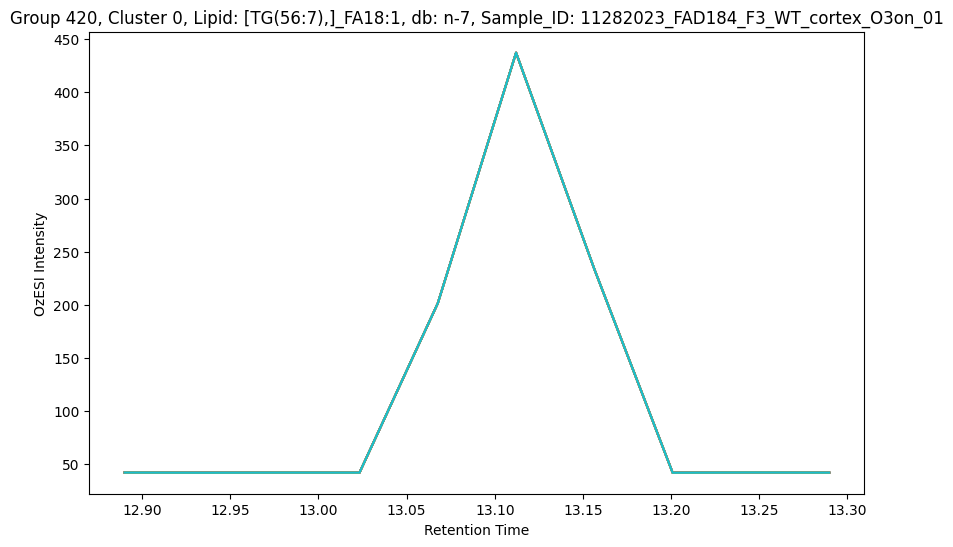

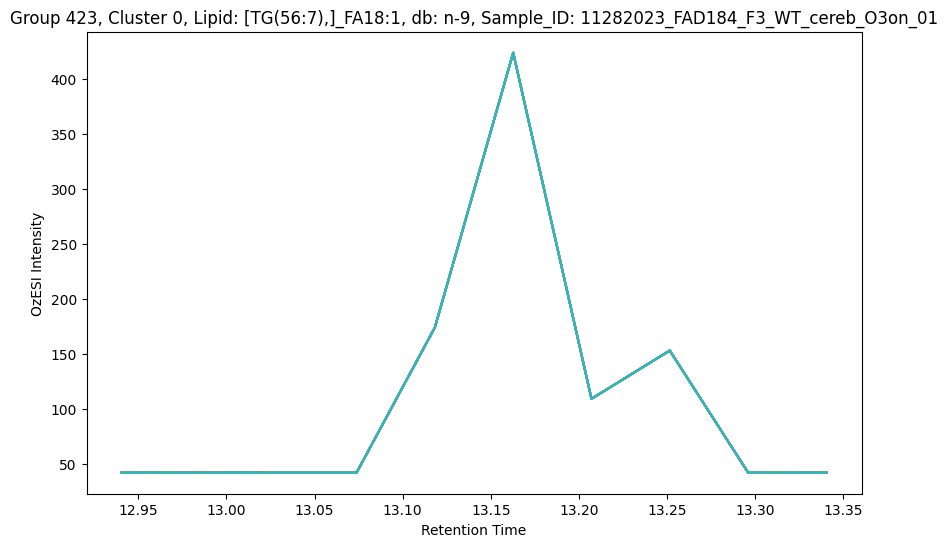

In [311]:
import matplotlib.pyplot as plt
import os

def plot_data(group_data, group, cluster_label, lipid_substring, save_dir):
    # Filter group_data for lipids containing the specified substring, if provided
    if lipid_substring:
        group_data = group_data[group_data['Lipid'].str.contains(lipid_substring)]

    if group_data.empty:
        return

    # Extracting data for plotting
    times = group_data['Retention_Time'].values
    intensities = group_data['OzESI_Intensity'].values

    # Plotting
    plt.figure(figsize=(10, 6))
    for _, row in group_data.iterrows():
        plt.plot(times, intensities, label=f"{row['Lipid']} Intensity")
    plt.xlabel('Retention Time')
    plt.ylabel('OzESI Intensity')

    # Extract additional information for the title
    lipid = group_data.iloc[0]['Lipid']
    db = group_data.iloc[0]['db']
    sample_id = group_data.iloc[0]['Sample_ID']
    plt.title(f'Group {group}, Cluster {cluster_label}, Lipid: {lipid}, db: {db}, Sample_ID: {sample_id}')

    # plt.legend()

    # Save the plot
    filename = f'Group_{group}_Cluster_{cluster_label}_Lipids_containing_{lipid_substring}.png'
    # Uncomment the line below to save the plot
    # plt.savefig(os.path.join(save_dir, filename), bbox_inches='tight')
    plt.show()
    plt.close()

# Define the directory to save the plots
save_directory = 'Projects/FaceFats/plots/peak_check/manual/'  # Replace with your directory path

# Specify the substring to search in the Lipid column
selected_lipid_substring = '56:7'  # Replace with the substring you want to search for

# Plotting for each group-cluster pair in d10
for (group, cluster_label), group_df in d10.groupby(['Group', 'Cluster_Label']):
    plot_data(group_df, group, cluster_label, selected_lipid_substring, save_directory)


# Calculate Area of peak

In [312]:
d11 = d10.copy()  # Creating d11 DataFrame from the newly filtered d10



# Create an empty DataFrame for storing the calculated areas
area_results = pd.DataFrame(columns=['Group', 'Cluster_Label', 'Area'])

# Group by 'Group' and 'Cluster_Label'
grouped_data = d11.groupby(['Group', 'Cluster_Label'])

# Iterate over each group and calculate the area
for (group, cluster_label), group_data in grouped_data:
    # Sort the group data by 'Retention_Time'
    sorted_group_data = group_data.sort_values(by='Retention_Time')

    # Extract 'Retention_Time' and 'OzESI_Intensity'
    retention_time = sorted_group_data['Retention_Time']
    intensity = sorted_group_data['OzESI_Intensity']

    # Calculate the area using the trapezoidal rule
    area = trapz(intensity, retention_time)

    # Append the results to the area_results DataFrame
    area_results = area_results.append({
        'Group': group, 
        'Cluster_Label': cluster_label, 
        'Area': area
    }, ignore_index=True)

# Merge the calculated areas back into the original DataFrame
d11 = pd.merge(d11, area_results, on=['Group', 'Cluster_Label'])

# Round the 'Area' to 0 decimal places
d11['Area'] = d11['Area'].round(0)
d11


,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,Match_Group,Lipid,Cage,Mouse,...,FAC,TG,Group,Cluster_Label,Max_Intensity,Cluster_RT,Cluster_Ground_Truth_Dif,RT_Start,RT_End,Area
0,788.7,599.5,11.793167,42.920002,11282023_DOD94_F3_WT_cortex_O3on_01,788.7 -> 599.5,1221,[TG(52:5)]_FA16:1,DOD94,F3,...,FA16:1,TG(52:5),48,0,1126.0,12.01520,0.01520,11.75,12.24,84.0
1,788.7,599.5,11.793417,42.900002,11282023_DOD94_F3_WT_cortex_O3on_01,788.7 -> 599.5,1221,[TG(52:5)]_FA16:1,DOD94,F3,...,FA16:1,TG(52:5),48,0,1126.0,12.01520,0.01520,11.75,12.24,84.0
2,788.7,599.5,11.837567,42.800003,11282023_DOD94_F3_WT_cortex_O3on_01,788.7 -> 599.5,1221,[TG(52:5)]_FA16:1,DOD94,F3,...,FA16:1,TG(52:5),48,0,1126.0,12.01520,0.01520,11.75,12.24,84.0
3,788.7,599.5,11.837833,42.760002,11282023_DOD94_F3_WT_cortex_O3on_01,788.7 -> 599.5,1221,[TG(52:5)]_FA16:1,DOD94,F3,...,FA16:1,TG(52:5),48,0,1126.0,12.01520,0.01520,11.75,12.24,84.0
4,788.7,599.5,11.881967,42.900002,11282023_DOD94_F3_WT_cortex_O3on_01,788.7 -> 599.5,1221,[TG(52:5)]_FA16:1,DOD94,F3,...,FA16:1,TG(52:5),48,0,1126.0,12.01520,0.01520,11.75,12.24,84.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741,796.7,607.5,18.052450,703.420044,11282023_FAD184_F3_WT_cereb_O3on_01,796.7 -> 607.5,1364,"[TG(55:8),TG(54:1)]_FA18:1",FAD184,F3,...,FA18:1,"TG(54:1), TG(55:8)",315,0,703.0,18.05245,1.13245,17.79,18.27,74.0
1742,796.7,607.5,18.096867,331.060028,11282023_FAD184_F3_WT_cereb_O3on_01,796.7 -> 607.5,1364,"[TG(55:8),TG(54:1)]_FA18:1",FAD184,F3,...,FA18:1,"TG(54:1), TG(55:8)",315,0,703.0,18.05245,1.13245,17.79,18.27,74.0
1743,796.7,607.5,18.141267,93.820007,11282023_FAD184_F3_WT_cereb_O3on_01,796.7 -> 607.5,1364,"[TG(55:8),TG(54:1)]_FA18:1",FAD184,F3,...,FA18:1,"TG(54:1), TG(55:8)",315,0,703.0,18.05245,1.13245,17.79,18.27,74.0
1744,796.7,607.5,18.185683,42.080002,11282023_FAD184_F3_WT_cereb_O3on_01,796.7 -> 607.5,1364,"[TG(55:8),TG(54:1)]_FA18:1",FAD184,F3,...,FA18:1,"TG(54:1), TG(55:8)",315,0,703.0,18.05245,1.13245,17.79,18.27,74.0


# Data Dependent Threshold (List of intensities)

In [313]:
d12 = d11.copy()

# Group the data by 'Group' and collect the 'OzESI_Intensity' values in lists
grouped_data = d12.groupby('Group')['OzESI_Intensity'].apply(list).reset_index(name='Group_Intensity')
# Merge the original data with the grouped data
d12 = d12.merge(grouped_data, on='Group')


# Sorting the lists in the 'Group_Intensity' column
d12['Group_Intensity'] = d12['Group_Intensity'].apply(lambda x: sorted(x))

d12  # Display the first few rows of the merged DataFrame



def set_threshold(group_intensity_list, threshold1=0.3, threshold2=0):
    """
    Function to set a threshold at a specified level of the list and add an additional value to it.

    :param group_intensity_list: List of intensity values for a group.
    :param threshold1: The percentage level at which to set the threshold (default is 0.3 for 30%).
    :param threshold2: An additional value to add to the threshold (default is 0).
    :return: The threshold value.
    """
    if not group_intensity_list:
        return None
    sorted_list = sorted(group_intensity_list)
    index = int(len(sorted_list) * threshold1)
    return sorted_list[index] + threshold2

# Example usage
# Assuming df_merged is your DataFrame with the 'Group_Intensity' column
d12['Group_Threshold'] = d12['Group_Intensity'].apply(lambda x: set_threshold(x, threshold1=0.15, threshold2=100))
#round the threshold to 0 decimal places
d12['Group_Threshold'] = d12['Group_Threshold'].round(0)


# To display the first few rows of the DataFrame with the new column
d12

# Filter the DataFrame to keep only the rows where 'OzESI_Intensity' is greater than or equal to 'Group_Threshold'
d13 = d12[d12['OzESI_Intensity'] >= d12['Group_Threshold']]

# Display the first few rows of the filtered DataFrame
d13




,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,Match_Group,Lipid,Cage,Mouse,...,Group,Cluster_Label,Max_Intensity,Cluster_RT,Cluster_Ground_Truth_Dif,RT_Start,RT_End,Area,Group_Intensity,Group_Threshold
8,788.7,599.5,11.970783,381.140015,11282023_DOD94_F3_WT_cortex_O3on_01,788.7 -> 599.5,1221,[TG(52:5)]_FA16:1,DOD94,F3,...,48,0,1126.0,12.015200,0.015200,11.75,12.24,84.0,"[42.68000411987305, 42.7400016784668, 42.76000...",143.0
9,788.7,599.5,11.971050,562.480042,11282023_DOD94_F3_WT_cortex_O3on_01,788.7 -> 599.5,1221,[TG(52:5)]_FA16:1,DOD94,F3,...,48,0,1126.0,12.015200,0.015200,11.75,12.24,84.0,"[42.68000411987305, 42.7400016784668, 42.76000...",143.0
10,788.7,599.5,12.015200,1125.940063,11282023_DOD94_F3_WT_cortex_O3on_01,788.7 -> 599.5,1221,[TG(52:5)]_FA16:1,DOD94,F3,...,48,0,1126.0,12.015200,0.015200,11.75,12.24,84.0,"[42.68000411987305, 42.7400016784668, 42.76000...",143.0
11,788.7,599.5,12.015450,364.040039,11282023_DOD94_F3_WT_cortex_O3on_01,788.7 -> 599.5,1221,[TG(52:5)]_FA16:1,DOD94,F3,...,48,0,1126.0,12.015200,0.015200,11.75,12.24,84.0,"[42.68000411987305, 42.7400016784668, 42.76000...",143.0
12,788.7,599.5,12.059600,264.200012,11282023_DOD94_F3_WT_cortex_O3on_01,788.7 -> 599.5,1221,[TG(52:5)]_FA16:1,DOD94,F3,...,48,0,1126.0,12.015200,0.015200,11.75,12.24,84.0,"[42.68000411987305, 42.7400016784668, 42.76000...",143.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1730,822.8,633.6,17.955433,369.880035,11282023_FAD184_F3_WT_cortex_O3on_01,822.8 -> 633.6,1885,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,...,471,0,511.0,17.911033,0.028967,17.69,18.18,64.0,"[42.02000427246094, 42.04000473022461, 42.0400...",142.0
1731,822.8,633.6,17.999850,252.960022,11282023_FAD184_F3_WT_cortex_O3on_01,822.8 -> 633.6,1885,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,...,471,0,511.0,17.911033,0.028967,17.69,18.18,64.0,"[42.02000427246094, 42.04000473022461, 42.0400...",142.0
1740,796.7,607.5,18.008050,324.900024,11282023_FAD184_F3_WT_cereb_O3on_01,796.7 -> 607.5,1364,"[TG(55:8),TG(54:1)]_FA18:1",FAD184,F3,...,315,0,703.0,18.052450,1.132450,17.79,18.27,74.0,"[41.980003356933594, 42.02000427246094, 42.040...",142.0
1741,796.7,607.5,18.052450,703.420044,11282023_FAD184_F3_WT_cereb_O3on_01,796.7 -> 607.5,1364,"[TG(55:8),TG(54:1)]_FA18:1",FAD184,F3,...,315,0,703.0,18.052450,1.132450,17.79,18.27,74.0,"[41.980003356933594, 42.02000427246094, 42.040...",142.0


# DDT Area Calculations 

In [314]:


# Assuming d5e is your original DataFrame
d14 = d13.copy()

# Create an empty DataFrame for storing the calculated areas
area_results_ddt = pd.DataFrame(columns=['Group', 'Cluster_Label', 'Area_DDT'])

# Group by 'Group' and 'Cluster_Label'
grouped_data_ddt = d14.groupby(['Group', 'Cluster_Label'])

# Iterate over each group and calculate the area
for (group, cluster_label), group_data in grouped_data_ddt:
    # Sort the group data by 'Retention_Time'
    sorted_group_data = group_data.sort_values(by='Retention_Time')

    # Extract 'Retention_Time' and 'OzESI_Intensity'
    retention_time = sorted_group_data['Retention_Time']
    intensity = sorted_group_data['OzESI_Intensity']

    # Calculate the area using the trapezoidal rule
    area = trapz(intensity, retention_time)

    # Append the results to the area_results_ddt DataFrame
    area_results_ddt = area_results_ddt.append({
        'Group': group, 
        'Cluster_Label': cluster_label, 
        'Area_DDT': area
    }, ignore_index=True)

# ... [previous code for calculating areas and appending to area_results_ddt] ...

# Merge the calculated areas back into the original DataFrame
d14 = pd.merge(d14, area_results_ddt, on=['Group', 'Cluster_Label'], how='left')

# Check if 'Area_DDT' is in d14 after merging
if 'Area_DDT' in d14.columns:
    # Round the 'Area_DDT' to 0 decimal places
    d14['Area_DDT'] = d14['Area_DDT'].round(0)
else:
    print("Area_DDT column not found in d14 after merging.")

# Display the DataFrame
d14






,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,Match_Group,Lipid,Cage,Mouse,...,Cluster_Label,Max_Intensity,Cluster_RT,Cluster_Ground_Truth_Dif,RT_Start,RT_End,Area,Group_Intensity,Group_Threshold,Area_DDT
0,788.7,599.5,11.970783,381.140015,11282023_DOD94_F3_WT_cortex_O3on_01,788.7 -> 599.5,1221,[TG(52:5)]_FA16:1,DOD94,F3,...,0,1126.0,12.015200,0.015200,11.75,12.24,84.0,"[42.68000411987305, 42.7400016784668, 42.76000...",143.0,59.0
1,788.7,599.5,11.971050,562.480042,11282023_DOD94_F3_WT_cortex_O3on_01,788.7 -> 599.5,1221,[TG(52:5)]_FA16:1,DOD94,F3,...,0,1126.0,12.015200,0.015200,11.75,12.24,84.0,"[42.68000411987305, 42.7400016784668, 42.76000...",143.0,59.0
2,788.7,599.5,12.015200,1125.940063,11282023_DOD94_F3_WT_cortex_O3on_01,788.7 -> 599.5,1221,[TG(52:5)]_FA16:1,DOD94,F3,...,0,1126.0,12.015200,0.015200,11.75,12.24,84.0,"[42.68000411987305, 42.7400016784668, 42.76000...",143.0,59.0
3,788.7,599.5,12.015450,364.040039,11282023_DOD94_F3_WT_cortex_O3on_01,788.7 -> 599.5,1221,[TG(52:5)]_FA16:1,DOD94,F3,...,0,1126.0,12.015200,0.015200,11.75,12.24,84.0,"[42.68000411987305, 42.7400016784668, 42.76000...",143.0,59.0
4,788.7,599.5,12.059600,264.200012,11282023_DOD94_F3_WT_cortex_O3on_01,788.7 -> 599.5,1221,[TG(52:5)]_FA16:1,DOD94,F3,...,0,1126.0,12.015200,0.015200,11.75,12.24,84.0,"[42.68000411987305, 42.7400016784668, 42.76000...",143.0,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,822.8,633.6,17.955433,369.880035,11282023_FAD184_F3_WT_cortex_O3on_01,822.8 -> 633.6,1885,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,...,0,511.0,17.911033,0.028967,17.69,18.18,64.0,"[42.02000427246094, 42.04000473022461, 42.0400...",142.0,33.0
964,822.8,633.6,17.999850,252.960022,11282023_FAD184_F3_WT_cortex_O3on_01,822.8 -> 633.6,1885,"[TG(57:9),TG(56:2)]_FA18:1",FAD184,F3,...,0,511.0,17.911033,0.028967,17.69,18.18,64.0,"[42.02000427246094, 42.04000473022461, 42.0400...",142.0,33.0
965,796.7,607.5,18.008050,324.900024,11282023_FAD184_F3_WT_cereb_O3on_01,796.7 -> 607.5,1364,"[TG(55:8),TG(54:1)]_FA18:1",FAD184,F3,...,0,703.0,18.052450,1.132450,17.79,18.27,74.0,"[41.980003356933594, 42.02000427246094, 42.040...",142.0,46.0
966,796.7,607.5,18.052450,703.420044,11282023_FAD184_F3_WT_cereb_O3on_01,796.7 -> 607.5,1364,"[TG(55:8),TG(54:1)]_FA18:1",FAD184,F3,...,0,703.0,18.052450,1.132450,17.79,18.27,74.0,"[41.980003356933594, 42.02000427246094, 42.040...",142.0,46.0


# Remove db not present and sort df 

In [315]:
#based on sample_ID Lipid and db pos, keep the unique value with the highest intensity
# Sort the DataFrame by 'OzESI_Intensity' in descending order to ensure the highest intensity is first

d15 = d14.copy()
# Assuming your DataFrame is named d15
d15 = d15[d15['db'] != '']
d15




#sort d15 by max OzESI_Intensity
d15 = d15.sort_values(by='OzESI_Intensity', ascending=False)

d15 = d15.groupby(['Lipid', 'Sample_ID', 'db']).first().reset_index()



#round the retention time to 2 decimal places
d15['Retention_Time'] = d15['Retention_Time'].round(2)
#round intensity to 0 decimal places
d15['OzESI_Intensity'] = d15['OzESI_Intensity'].round(0)

d15 = d15.sort_values(by=['Biology','Genotype','FAC', 'TG'])

d15

,Lipid,Sample_ID,db,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Transition,Match_Group,Cage,...,Cluster_Label,Max_Intensity,Cluster_RT,Cluster_Ground_Truth_Dif,RT_Start,RT_End,Area,Group_Intensity,Group_Threshold,Area_DDT
11,[TG(52:5)]_FA16:1,11282023_FAD185_M4_WT_cereb_O3on_01,n-7,788.7,599.5,12.02,26428.0,788.7 -> 599.5,1232,FAD185,...,0,26428.0,12.015183,0.015183,11.88,12.24,2988.0,"[42.96000289916992, 43.10000228881836, 424.940...",525.0,2903.0
12,[TG(52:5)]_FA16:1,11282023_FAD185_M4_WT_cereb_O3on_01,n-9,760.7,599.5,12.07,2939.0,760.7 -> 599.5,732,FAD185,...,0,2939.0,12.067500,0.067500,11.76,12.25,287.0,"[42.70000457763672, 42.840003967285156, 42.880...",143.0,271.0
0,[TG(50:3)]_FA18:1,11282023_DOD94_F3_WT_cereb_O3on_01,n-9,736.7,547.5,13.32,559.0,736.7 -> 547.5,420,DOD94,...,0,559.0,13.315600,0.025600,13.05,13.54,138.0,"[102.760009765625, 175.74000549316406, 190.360...",276.0,163.0
4,[TG(50:3)]_FA18:1,11282023_FAD185_M4_WT_cereb_O3on_01,n-7,764.7,547.5,13.27,881.0,764.7 -> 547.5,792,FAD185,...,0,881.0,13.265583,0.024417,13.09,13.58,91.0,"[42.80000305175781, 42.8800048828125, 42.90000...",143.0,56.0
5,[TG(50:3)]_FA18:1,11282023_FAD185_M4_WT_cereb_O3on_01,n-9,736.7,547.5,13.36,5801.0,736.7 -> 547.5,432,FAD185,...,0,5801.0,13.359983,0.069983,13.09,13.58,1077.0,"[52.480003356933594, 424.0600280761719, 831.38...",524.0,1039.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,"[TG(55:11),TG(54:4)]_FA18:1",11282023_FAD184_F3_WT_hippo_O3on_01,n-9,790.7,601.5,14.41,1672.0,790.7 -> 601.5,1267,FAD184,...,0,1672.0,14.412300,0.067700,14.19,14.68,335.0,"[42.560001373291016, 42.62000274658203, 120.78...",143.0,366.0
82,"[TG(55:11),TG(54:4)]_FA18:1",11282023_FAD184_F4_WT_hippo_O3on_01,n-9,790.7,601.5,14.46,509.0,790.7 -> 601.5,1271,FAD184,...,0,509.0,14.456683,0.023317,14.23,14.72,115.0,"[74.80000305175781, 137.44000244140625, 146.66...",237.0,44.0
89,"[TG(55:11),TG(54:4)]_FA18:1",11282023_FAD185_M4_WT_hippo_O3on_01,n-9,790.7,601.5,14.50,6223.0,790.7 -> 601.5,1275,FAD185,...,0,6223.0,14.501117,0.021117,14.23,14.72,700.0,"[262.9200134277344, 281.6400146484375, 330.780...",382.0,683.0
96,"[TG(55:11),TG(54:4)]_FA18:1",11282023_FAD189_M3_WT_hippo_O3on_01,n-9,790.7,601.5,14.50,981.0,790.7 -> 601.5,1279,FAD189,...,0,981.0,14.501100,0.021100,14.23,14.72,170.0,"[42.08000183105469, 42.18000411987305, 114.160...",142.0,160.0


Calculate Area Ratio

In [316]:
d16 = d15.copy()

# Filter for 'n-9' and 'n-7' in the 'db' column
filtered_df = d16[d16['db'].isin(['n-9', 'n-7'])]

# Group by 'Lipid' and 'Sample_ID'
grouped = filtered_df.groupby(['Lipid', 'Sample_ID'])

# DataFrame for Area Ratios
area_ratios = pd.DataFrame(columns=['Lipid', 'Sample_ID', 'Area_DDT_Ratio'])

# Calculate Area Ratio for each group
for (lipid, sample_id), group in grouped:
    n9_area = group[group['db'] == 'n-9']['Area_DDT'].sum()  # Sum if there are multiple 'n-9' entries
    n7_area = group[group['db'] == 'n-7']['Area_DDT'].sum()  # Sum if there are multiple 'n-7' entries
    ratio = round(n9_area / n7_area, 2) if n7_area != 0 else None

    # Append to DataFrame
    area_ratios = area_ratios.append({
        'Lipid': lipid,
        'Sample_ID': sample_id,
        'Area_DDT_Ratio': ratio
    }, ignore_index=True)

# Merge the Area Ratio DataFrame with the original DataFrame
d16 = pd.merge(d16, area_ratios, on=['Lipid', 'Sample_ID'], how='left')

d16 # Display the updated DataFrame with 'Area_Ratio'


,Lipid,Sample_ID,db,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Transition,Match_Group,Cage,...,Max_Intensity,Cluster_RT,Cluster_Ground_Truth_Dif,RT_Start,RT_End,Area,Group_Intensity,Group_Threshold,Area_DDT,Area_DDT_Ratio
0,[TG(52:5)]_FA16:1,11282023_FAD185_M4_WT_cereb_O3on_01,n-7,788.7,599.5,12.02,26428.0,788.7 -> 599.5,1232,FAD185,...,26428.0,12.015183,0.015183,11.88,12.24,2988.0,"[42.96000289916992, 43.10000228881836, 424.940...",525.0,2903.0,0.09
1,[TG(52:5)]_FA16:1,11282023_FAD185_M4_WT_cereb_O3on_01,n-9,760.7,599.5,12.07,2939.0,760.7 -> 599.5,732,FAD185,...,2939.0,12.067500,0.067500,11.76,12.25,287.0,"[42.70000457763672, 42.840003967285156, 42.880...",143.0,271.0,0.09
2,[TG(50:3)]_FA18:1,11282023_DOD94_F3_WT_cereb_O3on_01,n-9,736.7,547.5,13.32,559.0,736.7 -> 547.5,420,DOD94,...,559.0,13.315600,0.025600,13.05,13.54,138.0,"[102.760009765625, 175.74000549316406, 190.360...",276.0,163.0,NaN
3,[TG(50:3)]_FA18:1,11282023_FAD185_M4_WT_cereb_O3on_01,n-7,764.7,547.5,13.27,881.0,764.7 -> 547.5,792,FAD185,...,881.0,13.265583,0.024417,13.09,13.58,91.0,"[42.80000305175781, 42.8800048828125, 42.90000...",143.0,56.0,18.55
4,[TG(50:3)]_FA18:1,11282023_FAD185_M4_WT_cereb_O3on_01,n-9,736.7,547.5,13.36,5801.0,736.7 -> 547.5,432,FAD185,...,5801.0,13.359983,0.069983,13.09,13.58,1077.0,"[52.480003356933594, 424.0600280761719, 831.38...",524.0,1039.0,18.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,"[TG(55:11),TG(54:4)]_FA18:1",11282023_FAD184_F3_WT_hippo_O3on_01,n-9,790.7,601.5,14.41,1672.0,790.7 -> 601.5,1267,FAD184,...,1672.0,14.412300,0.067700,14.19,14.68,335.0,"[42.560001373291016, 42.62000274658203, 120.78...",143.0,366.0,NaN
141,"[TG(55:11),TG(54:4)]_FA18:1",11282023_FAD184_F4_WT_hippo_O3on_01,n-9,790.7,601.5,14.46,509.0,790.7 -> 601.5,1271,FAD184,...,509.0,14.456683,0.023317,14.23,14.72,115.0,"[74.80000305175781, 137.44000244140625, 146.66...",237.0,44.0,NaN
142,"[TG(55:11),TG(54:4)]_FA18:1",11282023_FAD185_M4_WT_hippo_O3on_01,n-9,790.7,601.5,14.50,6223.0,790.7 -> 601.5,1275,FAD185,...,6223.0,14.501117,0.021117,14.23,14.72,700.0,"[262.9200134277344, 281.6400146484375, 330.780...",382.0,683.0,NaN
143,"[TG(55:11),TG(54:4)]_FA18:1",11282023_FAD189_M3_WT_hippo_O3on_01,n-9,790.7,601.5,14.50,981.0,790.7 -> 601.5,1279,FAD189,...,981.0,14.501100,0.021100,14.23,14.72,170.0,"[42.08000183105469, 42.18000411987305, 114.160...",142.0,160.0,NaN


# Save df to results

In [317]:
# d16_save_directory = 'Projects/FaceFats/results/'
# d16.to_csv(os.path.join(d16_save_directory, 'LiverOzON_01Jan24.csv'), index=False)
d16

,Lipid,Sample_ID,db,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Transition,Match_Group,Cage,...,Max_Intensity,Cluster_RT,Cluster_Ground_Truth_Dif,RT_Start,RT_End,Area,Group_Intensity,Group_Threshold,Area_DDT,Area_DDT_Ratio
0,[TG(52:5)]_FA16:1,11282023_FAD185_M4_WT_cereb_O3on_01,n-7,788.7,599.5,12.02,26428.0,788.7 -> 599.5,1232,FAD185,...,26428.0,12.015183,0.015183,11.88,12.24,2988.0,"[42.96000289916992, 43.10000228881836, 424.940...",525.0,2903.0,0.09
1,[TG(52:5)]_FA16:1,11282023_FAD185_M4_WT_cereb_O3on_01,n-9,760.7,599.5,12.07,2939.0,760.7 -> 599.5,732,FAD185,...,2939.0,12.067500,0.067500,11.76,12.25,287.0,"[42.70000457763672, 42.840003967285156, 42.880...",143.0,271.0,0.09
2,[TG(50:3)]_FA18:1,11282023_DOD94_F3_WT_cereb_O3on_01,n-9,736.7,547.5,13.32,559.0,736.7 -> 547.5,420,DOD94,...,559.0,13.315600,0.025600,13.05,13.54,138.0,"[102.760009765625, 175.74000549316406, 190.360...",276.0,163.0,NaN
3,[TG(50:3)]_FA18:1,11282023_FAD185_M4_WT_cereb_O3on_01,n-7,764.7,547.5,13.27,881.0,764.7 -> 547.5,792,FAD185,...,881.0,13.265583,0.024417,13.09,13.58,91.0,"[42.80000305175781, 42.8800048828125, 42.90000...",143.0,56.0,18.55
4,[TG(50:3)]_FA18:1,11282023_FAD185_M4_WT_cereb_O3on_01,n-9,736.7,547.5,13.36,5801.0,736.7 -> 547.5,432,FAD185,...,5801.0,13.359983,0.069983,13.09,13.58,1077.0,"[52.480003356933594, 424.0600280761719, 831.38...",524.0,1039.0,18.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,"[TG(55:11),TG(54:4)]_FA18:1",11282023_FAD184_F3_WT_hippo_O3on_01,n-9,790.7,601.5,14.41,1672.0,790.7 -> 601.5,1267,FAD184,...,1672.0,14.412300,0.067700,14.19,14.68,335.0,"[42.560001373291016, 42.62000274658203, 120.78...",143.0,366.0,NaN
141,"[TG(55:11),TG(54:4)]_FA18:1",11282023_FAD184_F4_WT_hippo_O3on_01,n-9,790.7,601.5,14.46,509.0,790.7 -> 601.5,1271,FAD184,...,509.0,14.456683,0.023317,14.23,14.72,115.0,"[74.80000305175781, 137.44000244140625, 146.66...",237.0,44.0,NaN
142,"[TG(55:11),TG(54:4)]_FA18:1",11282023_FAD185_M4_WT_hippo_O3on_01,n-9,790.7,601.5,14.50,6223.0,790.7 -> 601.5,1275,FAD185,...,6223.0,14.501117,0.021117,14.23,14.72,700.0,"[262.9200134277344, 281.6400146484375, 330.780...",382.0,683.0,NaN
143,"[TG(55:11),TG(54:4)]_FA18:1",11282023_FAD189_M3_WT_hippo_O3on_01,n-9,790.7,601.5,14.50,981.0,790.7 -> 601.5,1279,FAD189,...,981.0,14.501100,0.021100,14.23,14.72,170.0,"[42.08000183105469, 42.18000411987305, 114.160...",142.0,160.0,NaN


# RT Window Drop peaks

In [338]:


# # Assuming d6 and df_db_pos are your DataFrames and user_window is the time window specified by the user
# user_window = 0.5  # Replace 0.5 with the value specified by the user

# # Copy d6 to d17
# d17 = d16.copy()

# # Iterate over each row in d17
# for index, row in d17.iterrows():
#     # Extract Lipid and Retention_Time from the row in d17
#     lipid = row['Lipid']
#     retention_time_d7 = row['Retention_Time']

#     # Find the corresponding row in df_db_pos
#     df_db_pos_row = df_db_pos[df_db_pos['Lipid'] == lipid]

#     # Check if the lipid was found in df_db_pos
#     if not df_db_pos_row.empty:
#         # Extract the Average_Retention_Time from df_db_pos
#         retention_time_db_pos = df_db_pos_row.iloc[0]['Retention_Time']

#         # Check if the retention time in d17 is outside the specified window
#         if abs(retention_time_d7 - retention_time_db_pos) > user_window:
#             # Remove the row from d17 if it is outside the window
#             d17.drop(index, inplace=True)


d17 = d16.copy()
def filter_d17_by_criteria(d17, df_db_pos, user_window):
    # Copy d17 to avoid modifying the original DataFrame
    filtered_d17 = d17.copy()

    # Iterate over each row in filtered_d17
    for index, row in filtered_d17.iterrows():
        # Extract Lipid, Biology, Genotype, Cage, Mouse, and Cluster_RT from the row
        lipid = row['Lipid']
        biology = row['Biology']
        genotype = row['Genotype']
        cage = row['Cage']
        mouse = row['Mouse']
        cluster_rt_d17 = row['Cluster_RT']  # Assuming 'Cluster_RT' is the column name

        # Find the corresponding row in df_db_pos
        df_db_pos_row = df_db_pos[
            (df_db_pos['Lipid'] == lipid) &
            (df_db_pos['Biology'] == biology) &
            (df_db_pos['Genotype'] == genotype) &
            (df_db_pos['Cage'] == cage) &
            (df_db_pos['Mouse'] == mouse)
        ]

        # Check if a matching row was found in df_db_pos
        if not df_db_pos_row.empty:
            # Extract the Retention_Time from df_db_pos
            retention_time_db_pos = df_db_pos_row.iloc[0]['Retention_Time']

            # Check if the Cluster_RT in d17 is outside the specified window of Retention_Time in df_db_pos
            if abs(cluster_rt_d17 - retention_time_db_pos) > user_window:
                # Remove the row from filtered_d17 if it is outside the window
                filtered_d17.drop(index, inplace=True)

    return filtered_d17

# Example usage:
user_window = .20  # Example window value
d17 = filter_d17_by_criteria(d17, df_db_pos, user_window)

d17
# # Filter for rows where 'Lipid' contains 'TG(52:5)' and FA16:1
# filtered_rows = d17[(d17['Lipid'].str.contains('TG\(54:2\)')) ]

# filtered_rows

,Lipid,Sample_ID,db,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Transition,Match_Group,Cage,...,Max_Intensity,Cluster_RT,Cluster_Ground_Truth_Dif,RT_Start,RT_End,Area,Group_Intensity,Group_Threshold,Area_DDT,Area_DDT_Ratio
0,[TG(52:5)]_FA16:1,11282023_FAD185_M4_WT_cereb_O3on_01,n-7,788.7,599.5,12.02,26428.0,788.7 -> 599.5,1232,FAD185,...,26428.0,12.015183,0.015183,11.88,12.24,2988.0,"[42.96000289916992, 43.10000228881836, 424.940...",525.0,2903.0,0.09
1,[TG(52:5)]_FA16:1,11282023_FAD185_M4_WT_cereb_O3on_01,n-9,760.7,599.5,12.07,2939.0,760.7 -> 599.5,732,FAD185,...,2939.0,12.067500,0.067500,11.76,12.25,287.0,"[42.70000457763672, 42.840003967285156, 42.880...",143.0,271.0,0.09
2,[TG(50:3)]_FA18:1,11282023_DOD94_F3_WT_cereb_O3on_01,n-9,736.7,547.5,13.32,559.0,736.7 -> 547.5,420,DOD94,...,559.0,13.315600,0.025600,13.05,13.54,138.0,"[102.760009765625, 175.74000549316406, 190.360...",276.0,163.0,NaN
3,[TG(50:3)]_FA18:1,11282023_FAD185_M4_WT_cereb_O3on_01,n-7,764.7,547.5,13.27,881.0,764.7 -> 547.5,792,FAD185,...,881.0,13.265583,0.024417,13.09,13.58,91.0,"[42.80000305175781, 42.8800048828125, 42.90000...",143.0,56.0,18.55
4,[TG(50:3)]_FA18:1,11282023_FAD185_M4_WT_cereb_O3on_01,n-9,736.7,547.5,13.36,5801.0,736.7 -> 547.5,432,FAD185,...,5801.0,13.359983,0.069983,13.09,13.58,1077.0,"[52.480003356933594, 424.0600280761719, 831.38...",524.0,1039.0,18.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,"[TG(55:11),TG(54:4)]_FA18:1",11282023_FAD184_F3_WT_hippo_O3on_01,n-9,790.7,601.5,14.41,1672.0,790.7 -> 601.5,1267,FAD184,...,1672.0,14.412300,0.067700,14.19,14.68,335.0,"[42.560001373291016, 42.62000274658203, 120.78...",143.0,366.0,NaN
141,"[TG(55:11),TG(54:4)]_FA18:1",11282023_FAD184_F4_WT_hippo_O3on_01,n-9,790.7,601.5,14.46,509.0,790.7 -> 601.5,1271,FAD184,...,509.0,14.456683,0.023317,14.23,14.72,115.0,"[74.80000305175781, 137.44000244140625, 146.66...",237.0,44.0,NaN
142,"[TG(55:11),TG(54:4)]_FA18:1",11282023_FAD185_M4_WT_hippo_O3on_01,n-9,790.7,601.5,14.50,6223.0,790.7 -> 601.5,1275,FAD185,...,6223.0,14.501117,0.021117,14.23,14.72,700.0,"[262.9200134277344, 281.6400146484375, 330.780...",382.0,683.0,NaN
143,"[TG(55:11),TG(54:4)]_FA18:1",11282023_FAD189_M3_WT_hippo_O3on_01,n-9,790.7,601.5,14.50,981.0,790.7 -> 601.5,1279,FAD189,...,981.0,14.501100,0.021100,14.23,14.72,170.0,"[42.08000183105469, 42.18000411987305, 114.160...",142.0,160.0,NaN


# Plot stacked bar plot 

In [339]:
d17

,Lipid,Sample_ID,db,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Transition,Match_Group,Cage,...,Max_Intensity,Cluster_RT,Cluster_Ground_Truth_Dif,RT_Start,RT_End,Area,Group_Intensity,Group_Threshold,Area_DDT,Area_DDT_Ratio
0,[TG(52:5)]_FA16:1,11282023_FAD185_M4_WT_cereb_O3on_01,n-7,788.7,599.5,12.02,26428.0,788.7 -> 599.5,1232,FAD185,...,26428.0,12.015183,0.015183,11.88,12.24,2988.0,"[42.96000289916992, 43.10000228881836, 424.940...",525.0,2903.0,0.09
1,[TG(52:5)]_FA16:1,11282023_FAD185_M4_WT_cereb_O3on_01,n-9,760.7,599.5,12.07,2939.0,760.7 -> 599.5,732,FAD185,...,2939.0,12.067500,0.067500,11.76,12.25,287.0,"[42.70000457763672, 42.840003967285156, 42.880...",143.0,271.0,0.09
2,[TG(50:3)]_FA18:1,11282023_DOD94_F3_WT_cereb_O3on_01,n-9,736.7,547.5,13.32,559.0,736.7 -> 547.5,420,DOD94,...,559.0,13.315600,0.025600,13.05,13.54,138.0,"[102.760009765625, 175.74000549316406, 190.360...",276.0,163.0,NaN
3,[TG(50:3)]_FA18:1,11282023_FAD185_M4_WT_cereb_O3on_01,n-7,764.7,547.5,13.27,881.0,764.7 -> 547.5,792,FAD185,...,881.0,13.265583,0.024417,13.09,13.58,91.0,"[42.80000305175781, 42.8800048828125, 42.90000...",143.0,56.0,18.55
4,[TG(50:3)]_FA18:1,11282023_FAD185_M4_WT_cereb_O3on_01,n-9,736.7,547.5,13.36,5801.0,736.7 -> 547.5,432,FAD185,...,5801.0,13.359983,0.069983,13.09,13.58,1077.0,"[52.480003356933594, 424.0600280761719, 831.38...",524.0,1039.0,18.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,"[TG(55:11),TG(54:4)]_FA18:1",11282023_FAD184_F3_WT_hippo_O3on_01,n-9,790.7,601.5,14.41,1672.0,790.7 -> 601.5,1267,FAD184,...,1672.0,14.412300,0.067700,14.19,14.68,335.0,"[42.560001373291016, 42.62000274658203, 120.78...",143.0,366.0,NaN
141,"[TG(55:11),TG(54:4)]_FA18:1",11282023_FAD184_F4_WT_hippo_O3on_01,n-9,790.7,601.5,14.46,509.0,790.7 -> 601.5,1271,FAD184,...,509.0,14.456683,0.023317,14.23,14.72,115.0,"[74.80000305175781, 137.44000244140625, 146.66...",237.0,44.0,NaN
142,"[TG(55:11),TG(54:4)]_FA18:1",11282023_FAD185_M4_WT_hippo_O3on_01,n-9,790.7,601.5,14.50,6223.0,790.7 -> 601.5,1275,FAD185,...,6223.0,14.501117,0.021117,14.23,14.72,700.0,"[262.9200134277344, 281.6400146484375, 330.780...",382.0,683.0,NaN
143,"[TG(55:11),TG(54:4)]_FA18:1",11282023_FAD189_M3_WT_hippo_O3on_01,n-9,790.7,601.5,14.50,981.0,790.7 -> 601.5,1279,FAD189,...,981.0,14.501100,0.021100,14.23,14.72,170.0,"[42.08000183105469, 42.18000411987305, 114.160...",142.0,160.0,NaN


In [340]:
# Step 1: Create d18 as a copy of d24
d18 = d17.copy()

# Step 2: Define the columns to be dropped
dropped_columns = ['Transition', 'Group_Threshold', 'Group_Intensity', 'Cluster_Label', 'RT_Start','RT_End']

# Step 3: Drop the specified columns from d18
d18.drop(columns=dropped_columns, inplace=True)

# d18 now has the specified columns dropped
d18

,Lipid,Sample_ID,db,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Match_Group,Cage,Mouse,...,Group_Sample,FAC,TG,Group,Max_Intensity,Cluster_RT,Cluster_Ground_Truth_Dif,Area,Area_DDT,Area_DDT_Ratio
0,[TG(52:5)]_FA16:1,11282023_FAD185_M4_WT_cereb_O3on_01,n-7,788.7,599.5,12.02,26428.0,1232,FAD185,M4,...,-1,FA16:1,TG(52:5),47,26428.0,12.015183,0.015183,2988.0,2903.0,0.09
1,[TG(52:5)]_FA16:1,11282023_FAD185_M4_WT_cereb_O3on_01,n-9,760.7,599.5,12.07,2939.0,732,FAD185,M4,...,-1,FA16:1,TG(52:5),52,2939.0,12.067500,0.067500,287.0,271.0,0.09
2,[TG(50:3)]_FA18:1,11282023_DOD94_F3_WT_cereb_O3on_01,n-9,736.7,547.5,13.32,559.0,420,DOD94,F3,...,-1,FA18:1,TG(50:3),27,559.0,13.315600,0.025600,138.0,163.0,NaN
3,[TG(50:3)]_FA18:1,11282023_FAD185_M4_WT_cereb_O3on_01,n-7,764.7,547.5,13.27,881.0,792,FAD185,M4,...,-1,FA18:1,TG(50:3),20,881.0,13.265583,0.024417,91.0,56.0,18.55
4,[TG(50:3)]_FA18:1,11282023_FAD185_M4_WT_cereb_O3on_01,n-9,736.7,547.5,13.36,5801.0,432,FAD185,M4,...,-1,FA18:1,TG(50:3),29,5801.0,13.359983,0.069983,1077.0,1039.0,18.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,"[TG(55:11),TG(54:4)]_FA18:1",11282023_FAD184_F3_WT_hippo_O3on_01,n-9,790.7,601.5,14.41,1672.0,1267,FAD184,F3,...,-1,FA18:1,"TG(54:4), TG(55:11)",296,1672.0,14.412300,0.067700,335.0,366.0,NaN
141,"[TG(55:11),TG(54:4)]_FA18:1",11282023_FAD184_F4_WT_hippo_O3on_01,n-9,790.7,601.5,14.46,509.0,1271,FAD184,F4,...,-1,FA18:1,"TG(54:4), TG(55:11)",297,509.0,14.456683,0.023317,115.0,44.0,NaN
142,"[TG(55:11),TG(54:4)]_FA18:1",11282023_FAD185_M4_WT_hippo_O3on_01,n-9,790.7,601.5,14.50,6223.0,1275,FAD185,M4,...,-1,FA18:1,"TG(54:4), TG(55:11)",298,6223.0,14.501117,0.021117,700.0,683.0,NaN
143,"[TG(55:11),TG(54:4)]_FA18:1",11282023_FAD189_M3_WT_hippo_O3on_01,n-9,790.7,601.5,14.50,981.0,1279,FAD189,M3,...,-1,FA18:1,"TG(54:4), TG(55:11)",299,981.0,14.501100,0.021100,170.0,160.0,NaN


# make mouse column

In [341]:
# Extracting the mouse name from the 'Sample_ID' column
d18['Mouse'] = d18['Sample_ID'].apply(lambda x: '_'.join(x.split('_')[1:3]))
d18

,Lipid,Sample_ID,db,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Match_Group,Cage,Mouse,...,Group_Sample,FAC,TG,Group,Max_Intensity,Cluster_RT,Cluster_Ground_Truth_Dif,Area,Area_DDT,Area_DDT_Ratio
0,[TG(52:5)]_FA16:1,11282023_FAD185_M4_WT_cereb_O3on_01,n-7,788.7,599.5,12.02,26428.0,1232,FAD185,FAD185_M4,...,-1,FA16:1,TG(52:5),47,26428.0,12.015183,0.015183,2988.0,2903.0,0.09
1,[TG(52:5)]_FA16:1,11282023_FAD185_M4_WT_cereb_O3on_01,n-9,760.7,599.5,12.07,2939.0,732,FAD185,FAD185_M4,...,-1,FA16:1,TG(52:5),52,2939.0,12.067500,0.067500,287.0,271.0,0.09
2,[TG(50:3)]_FA18:1,11282023_DOD94_F3_WT_cereb_O3on_01,n-9,736.7,547.5,13.32,559.0,420,DOD94,DOD94_F3,...,-1,FA18:1,TG(50:3),27,559.0,13.315600,0.025600,138.0,163.0,NaN
3,[TG(50:3)]_FA18:1,11282023_FAD185_M4_WT_cereb_O3on_01,n-7,764.7,547.5,13.27,881.0,792,FAD185,FAD185_M4,...,-1,FA18:1,TG(50:3),20,881.0,13.265583,0.024417,91.0,56.0,18.55
4,[TG(50:3)]_FA18:1,11282023_FAD185_M4_WT_cereb_O3on_01,n-9,736.7,547.5,13.36,5801.0,432,FAD185,FAD185_M4,...,-1,FA18:1,TG(50:3),29,5801.0,13.359983,0.069983,1077.0,1039.0,18.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,"[TG(55:11),TG(54:4)]_FA18:1",11282023_FAD184_F3_WT_hippo_O3on_01,n-9,790.7,601.5,14.41,1672.0,1267,FAD184,FAD184_F3,...,-1,FA18:1,"TG(54:4), TG(55:11)",296,1672.0,14.412300,0.067700,335.0,366.0,NaN
141,"[TG(55:11),TG(54:4)]_FA18:1",11282023_FAD184_F4_WT_hippo_O3on_01,n-9,790.7,601.5,14.46,509.0,1271,FAD184,FAD184_F4,...,-1,FA18:1,"TG(54:4), TG(55:11)",297,509.0,14.456683,0.023317,115.0,44.0,NaN
142,"[TG(55:11),TG(54:4)]_FA18:1",11282023_FAD185_M4_WT_hippo_O3on_01,n-9,790.7,601.5,14.50,6223.0,1275,FAD185,FAD185_M4,...,-1,FA18:1,"TG(54:4), TG(55:11)",298,6223.0,14.501117,0.021117,700.0,683.0,NaN
143,"[TG(55:11),TG(54:4)]_FA18:1",11282023_FAD189_M3_WT_hippo_O3on_01,n-9,790.7,601.5,14.50,981.0,1279,FAD189,FAD189_M3,...,-1,FA18:1,"TG(54:4), TG(55:11)",299,981.0,14.501100,0.021100,170.0,160.0,NaN


# Group by Sample Lipid Biology Genotype and sort by FA16:1 FA18:1

In [342]:
d18['SLBG_group'] = d18.groupby(['Lipid', 'Sample_ID','Biology','Genotype']).ngroup()
d18 = d18.sort_values(by=['FAC', 'Lipid'], ascending=[True, True])

# If you specifically want 'FA16:1' to appear before 'FA18:1'
# You might need a custom sorting function or a categorical type for the 'Lipid_End' column
d18['FAC'] = pd.Categorical(d18['FAC'], categories=['FA16:1', 'FA18:1'], ordered=True)
d18 = d18.sort_values(by=['FAC', 'Lipid'])
d18

,Lipid,Sample_ID,db,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Match_Group,Cage,Mouse,...,FAC,TG,Group,Max_Intensity,Cluster_RT,Cluster_Ground_Truth_Dif,Area,Area_DDT,Area_DDT_Ratio,SLBG_group
0,[TG(52:5)]_FA16:1,11282023_FAD185_M4_WT_cereb_O3on_01,n-7,788.7,599.5,12.02,26428.0,1232,FAD185,FAD185_M4,...,FA16:1,TG(52:5),47,26428.0,12.015183,0.015183,2988.0,2903.0,0.09,9
1,[TG(52:5)]_FA16:1,11282023_FAD185_M4_WT_cereb_O3on_01,n-9,760.7,599.5,12.07,2939.0,732,FAD185,FAD185_M4,...,FA16:1,TG(52:5),52,2939.0,12.067500,0.067500,287.0,271.0,0.09,9
44,[TG(52:5)]_FA16:1,11282023_DOD94_F3_WT_cortex_O3on_01,n-7,788.7,599.5,12.02,1126.0,1221,DOD94,DOD94_F3,...,FA16:1,TG(52:5),48,1126.0,12.015200,0.015200,84.0,59.0,0.00,7
45,[TG(52:5)]_FA16:1,11282023_FAD184_F3_WT_cortex_O3on_01,n-7,788.7,599.5,12.02,3221.0,1225,FAD184,FAD184_F3,...,FA16:1,TG(52:5),49,3221.0,12.015450,0.015450,279.0,273.0,0.00,8
46,[TG(52:5)]_FA16:1,11282023_FAD185_M4_WT_cortex_O3on_01,n-7,788.7,599.5,12.02,16896.0,1233,FAD185,FAD185_M4,...,FA16:1,TG(52:5),50,16896.0,12.015200,0.015200,1701.0,1677.0,0.15,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,"[TG(57:11),TG(56:4)]_FA18:1",11282023_FAD185_M4_WT_cortex_O3on_01,n-9,818.7,629.5,15.65,472.0,1813,FAD185,FAD185_M4,...,FA18:1,"TG(56:4), TG(57:11)",443,472.0,15.647717,0.162283,64.0,58.0,NaN,92
42,"[TG(57:12),TG(56:5)]_FA18:1",11282023_FAD184_F3_WT_cereb_O3on_01,n-9,816.7,627.5,14.76,419.0,1764,FAD184,FAD184_F3,...,FA18:1,"TG(56:5), TG(57:12)",456,419.0,14.760150,0.069850,49.0,16.0,NaN,93
39,"[TG(57:9),TG(56:2)]_FA18:1",11282023_FAD184_F3_WT_cereb_O3on_01,n-9,822.8,633.6,17.91,436.0,1884,FAD184,FAD184_F3,...,FA18:1,"TG(56:2), TG(57:9)",469,436.0,17.911017,0.028983,77.0,43.0,NaN,95
85,"[TG(57:9),TG(56:2)]_FA18:1",11282023_DOD94_F3_WT_cortex_O3on_01,n-9,822.8,633.6,17.91,679.0,1881,DOD94,DOD94_F3,...,FA18:1,"TG(56:2), TG(57:9)",470,679.0,17.911000,0.029000,90.0,84.0,NaN,94


# Save results

In [356]:
# save_results_directory = 'Projects/FaceFats/results/'
# save_results_name = 'BrainWT_OzON_Truth_Results_14Jan2024'
# file_extension = '.csv'
# file_number = 1
# full_path = os.path.join(save_results_directory, f'{save_results_name}{file_extension}')


# # Check if file exists and increment the number suffix until an unused filename is found
# while os.path.exists(full_path):
#     full_path = os.path.join(save_results_directory, f'{save_results_name}_{file_number}{file_extension}')
#     file_number += 1

# # Save the dataframe to the new path
# d18.to_csv(full_path, index=False)
d18.to_excel('Projects/FaceFats/results/BrainWT_OzON_Truth_Results_14Jan2024.xlsx', index=False)
d18.to_csv('Projects/FaceFats/results/BrainWT_OzON_Truth_Results_14Jan2024.csv', index=False)

# Load Results

In [357]:
# # Example usage:
# d_load = pd.read_csv('Projects/FaceFats/results/Brain5xFAD_OzON_Results_04Jan2024_7.csv')

# Create DB columns for pviot table n7 n9 n10 n12 focus on Brain 5xFAD only

In [358]:
#use d18 or dload

# # Filtering for WT Genotype
df_WT = d18[d18['Genotype'] == 'WT']
# df_WT = d_load[d_load['Genotype'] == 'WT']

# Step 1: Filter for non-liver samples and rename to df_brain_WT
df_brain_WT = df_WT[df_WT['Biology'] != 'liver']

# Step 1: Filter for non-liver samples and rename to df_brain_WT
df_brain_WT = df_WT[df_WT['Biology'] != 'liver']
df_brain_WT_cereb = df_brain_WT[df_brain_WT['Biology'] == 'cereb']
df_brain_WT_cortex = df_brain_WT[df_brain_WT['Biology'] == 'cortex']
df_brain_WT_hippo = df_brain_WT[df_brain_WT['Biology'] == 'hippo']
df_brain_WT_dienc = df_brain_WT[df_brain_WT['Biology'] == 'dienc']

def process_n_percent(df):
    # Create and fill n-7, n-9, n-10, n-12 columns
    for col in ['n-7', 'n-9', 'n-10', 'n-12']:
        df[col] = df.apply(lambda x: x['Area'] if x['db'] == col else 0, axis=1)

    # Group by 'Lipid' and sum up the n columns
    df_grouped = df.groupby('Lipid')[['n-7', 'n-9', 'n-10', 'n-12']].sum().round(0).reset_index()

    # Calculate total intensity
    df_grouped['Total_Intensity'] = df_grouped[['n-7', 'n-9', 'n-10', 'n-12']].sum(axis=1)

    # Calculate relative intensities
    for col in ['n-7', 'n-9', 'n-10', 'n-12']:
        df_grouped[col + '%'] = ((df_grouped[col] / df_grouped['Total_Intensity']) * 100).round(1)

    # Return the new dataframe
    return df_grouped

#Example usage:
df_brain_WT2 = process_n_percent(df_brain_WT)
df_brain_WT_cereb2 = process_n_percent(df_brain_WT_cereb)
df_brain_WT_cortex2 = process_n_percent(df_brain_WT_cortex)
df_brain_WT_hippo2 = process_n_percent(df_brain_WT_hippo)
df_brain_WT_dienc2 = process_n_percent(df_brain_WT_dienc)



# Display the final DataFrame df_brain_WT2
df_brain_WT2
df_brain_WT_cereb2
df_brain_WT_cortex2
df_brain_WT_hippo2
df_brain_WT_dienc2


/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Lipid,n-7,n-9,n-10,n-12,Total_Intensity,n-7%,n-9%,n-10%,n-12%
0,[TG(50:3)]_FA18:1,0.0,116.0,0,0,116.0,0.0,100.0,0.0,0.0
1,[TG(54:5)]_FA18:1,61.0,400.0,0,0,461.0,13.2,86.8,0.0,0.0
2,"[TG(55:10),TG(54:3)]_FA18:1",538.0,12435.0,0,0,12973.0,4.1,95.9,0.0,0.0
3,"[TG(55:11),TG(54:4)]_FA18:1",436.0,5151.0,0,0,5587.0,7.8,92.2,0.0,0.0
4,"[TG(55:9),TG(54:2)]_FA18:1",256.0,2940.0,0,0,3196.0,8.0,92.0,0.0,0.0


# create total intensity and column for FA 16 18

In [359]:
# Grouping by 'Lipid' and summing up the n-7, n-9, n-10, and n-12 columns
df_brain_WT2 = df_brain_WT.groupby('Lipid')[['n-7', 'n-9', 'n-10', 'n-12']].sum().round(0).reset_index()
#Creating a new column 'Total Intensity' in df_brain_WT2
df_brain_WT2['Total_Intensity'] = df_brain_WT2[['n-7', 'n-9', 'n-10', 'n-12']].sum(axis=1)

# Create the 'FA' column
df_brain_WT2['FA'] = df_brain_WT2['Lipid'].apply(lambda x: '16' if 'FA16:1' in x else ('18' if 'FA18:1' in x else 'Other'))

# Sort the DataFrame by the 'FA' column
df_brain_WT2.sort_values(by='FA', inplace=True)
#reset index
df_brain_WT2.reset_index(drop=True, inplace=True)
# Displaying df4
df_brain_WT2

,Lipid,n-7,n-9,n-10,n-12,Total_Intensity,FA
0,[TG(52:5)]_FA16:1,5052.0,557.0,0.0,0,5609.0,16
1,"[TG(55:11),TG(54:4)]_FA16:1",120.0,0.0,0.0,0,120.0,16
2,[TG(50:3)]_FA18:1,163.0,2485.0,0.0,0,2648.0,18
3,[TG(54:5)]_FA18:1,1156.0,6407.0,0.0,0,7563.0,18
4,[TG(54:6)]_FA18:1,0.0,475.0,0.0,0,475.0,18
5,"[TG(55:10),TG(54:3)]_FA18:1",4806.0,71713.0,0.0,0,76519.0,18
6,"[TG(55:11),TG(54:4)]_FA18:1",4204.0,36437.0,0.0,0,40641.0,18
7,"[TG(55:8),TG(54:1)]_FA18:1",0.0,313.0,0.0,0,313.0,18
8,"[TG(55:9),TG(54:2)]_FA18:1",1107.0,13937.0,165.0,0,15209.0,18
9,"[TG(56:7),]_FA18:1",50.0,48.0,0.0,0,98.0,18


# add n% FAC and TG columns 

In [360]:
# Creating a new dataframe df_brain_WT3 from df_liver2
df_brain_WT3 = df_brain_WT2.copy()

# Calculating the relative intensity of each db_pos for each lipid
for col in ['n-7', 'n-9', 'n-10', 'n-12']:
    df_brain_WT3[col + '%'] = ((df_brain_WT3[col] / df_brain_WT3['Total_Intensity']) * 100).round(1)


# Function to determine the value for the FAC column
def determine_fac(lipid):
    if 'FA18:1' in lipid:
        return 'FA18:1'
    elif 'FA16:1' in lipid:
        return 'FA16:1'
    else:
        return None  # or some other default value

# Apply the function to the Lipid column to create the FAC column
df_brain_WT3['FAC'] = df_brain_WT3['Lipid'].apply(determine_fac)

import pandas as pd
import re

# Function to extract TG values
def extract_tg(lipid):
    # Regular expression pattern to match TG(##:#) or similar patterns
    pattern = r'TG\(\d+:\d+\)'
    matches = re.findall(pattern, lipid)
    return ', '.join(matches) if matches else None

# Apply the function to the Lipid column to create the TG column
df_brain_WT3['TG'] = df_brain_WT3['Lipid'].apply(extract_tg)




# Function to sort TG values within a cell
def sort_tg_values(tg_cell):
    if not pd.isna(tg_cell) and ', ' in tg_cell:
        tg_list = tg_cell.split(', ')
        tg_list_sorted = sorted(tg_list, key=lambda x: [int(i) for i in x[3:-1].split(':')])
        return ', '.join(tg_list_sorted)
    else:
        return tg_cell

# Apply the function to the TG column
df_brain_WT3['TG'] = df_brain_WT3['TG'].apply(sort_tg_values)
df_brain_WT3 = df_brain_WT3.sort_values(by=['FAC', 'TG'])
import pandas as pd
import re

# Function to remove TG(##:0) patterns from the Lipid string
def remove_tg_zero(lipid):
    # Pattern to match TG(##:0)
    pattern = r'TG\(\d+:0\)'
    # Remove TG(##:0) patterns
    new_lipid = re.sub(pattern, '', lipid)
    # Remove any extra commas and spaces left after removal
    new_lipid = re.sub(r',\s+', ', ', new_lipid).strip(', ')
    return new_lipid

# Apply the function to the Lipid column
df_brain_WT3['Lipid'] = df_brain_WT3['Lipid'].apply(remove_tg_zero)

# Continue with the rest of your code for sorting
# ... [rest of your code] ...

# Displaying df_l


# Displaying df_brain_WT3 with the new relative intensity columns
df_brain_WT3


,Lipid,n-7,n-9,n-10,n-12,Total_Intensity,FA,n-7%,n-9%,n-10%,n-12%,FAC,TG
0,[TG(52:5)]_FA16:1,5052.0,557.0,0.0,0,5609.0,16,90.1,9.9,0.0,0.0,FA16:1,TG(52:5)
1,"[TG(55:11),TG(54:4)]_FA16:1",120.0,0.0,0.0,0,120.0,16,100.0,0.0,0.0,0.0,FA16:1,"TG(54:4), TG(55:11)"
2,[TG(50:3)]_FA18:1,163.0,2485.0,0.0,0,2648.0,18,6.2,93.8,0.0,0.0,FA18:1,TG(50:3)
7,"[TG(55:8),TG(54:1)]_FA18:1",0.0,313.0,0.0,0,313.0,18,0.0,100.0,0.0,0.0,FA18:1,"TG(54:1), TG(55:8)"
8,"[TG(55:9),TG(54:2)]_FA18:1",1107.0,13937.0,165.0,0,15209.0,18,7.3,91.6,1.1,0.0,FA18:1,"TG(54:2), TG(55:9)"
5,"[TG(55:10),TG(54:3)]_FA18:1",4806.0,71713.0,0.0,0,76519.0,18,6.3,93.7,0.0,0.0,FA18:1,"TG(54:3), TG(55:10)"
6,"[TG(55:11),TG(54:4)]_FA18:1",4204.0,36437.0,0.0,0,40641.0,18,10.3,89.7,0.0,0.0,FA18:1,"TG(54:4), TG(55:11)"
3,[TG(54:5)]_FA18:1,1156.0,6407.0,0.0,0,7563.0,18,15.3,84.7,0.0,0.0,FA18:1,TG(54:5)
4,[TG(54:6)]_FA18:1,0.0,475.0,0.0,0,475.0,18,0.0,100.0,0.0,0.0,FA18:1,TG(54:6)
12,"[TG(57:9),TG(56:2)]_FA18:1",0.0,231.0,0.0,0,231.0,18,0.0,100.0,0.0,0.0,FA18:1,"TG(56:2), TG(57:9)"


# Create pivot table from data above

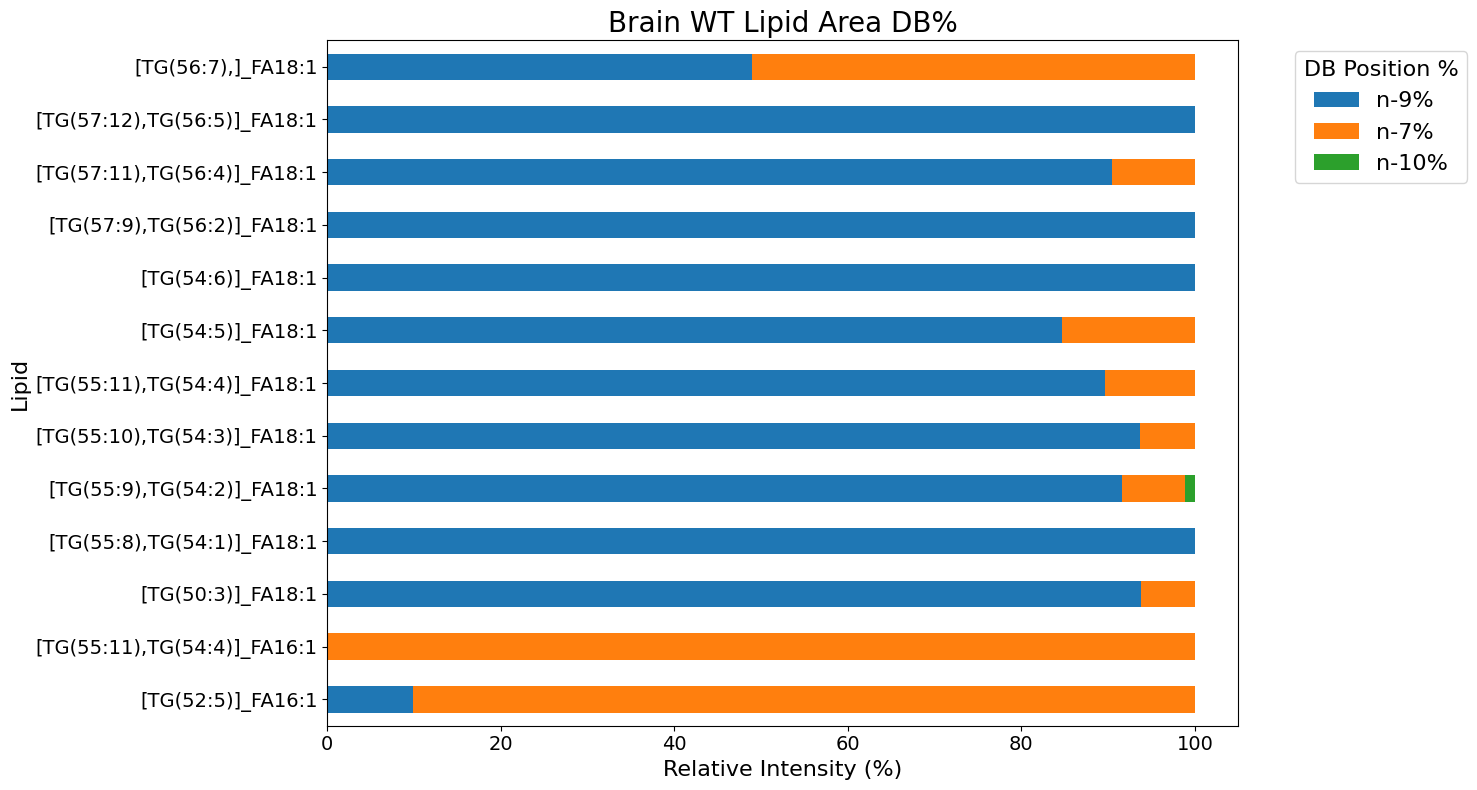

In [369]:
# Reshaping the DataFrame
reshaped_df = df_brain_WT3.melt(id_vars='Lipid', value_vars=['n-7%', 'n-9%', 'n-10%', 'n-12%'], var_name='db', value_name='Percentage')


# reshaped_df = reshaped_df[~reshaped_df['Lipid'].str.contains('FA18:2')]

reshaped_df


# Creating a pivot table
pivot_df = reshaped_df.pivot_table(index='Lipid', columns='db', values='Percentage', aggfunc='sum')


# Function to generate a combined sorting key
def combined_sort_key(lipid):
    # Check if lipid contains 'FA16:1'
    fa16_1_key = '0' if 'FA16:1' in lipid else '1'  # '0' for FA16:1, '1' otherwise

    # Extract and sort TG values
    tg_list = re.findall(r'TG\(\d+:\d+\)', lipid)
    tg_list_sorted = ', '.join(sorted(tg_list, key=lambda x: [int(i) for i in x[3:-1].split(':')]))

    # Combine the keys
    return fa16_1_key + tg_list_sorted + lipid

# Apply the combined sorting function to the Lipid index to create a sorting key
pivot_df['Combined_Sort_Key'] = pivot_df.index.to_series().apply(combined_sort_key)


# Sort the DataFrame by the combined sorting key
pivot_df = pivot_df.sort_values(by='Combined_Sort_Key')

# Drop the combined sorting key column
pivot_df.drop('Combined_Sort_Key', axis=1, inplace=True)

# Reordering the columns to make n-9% appear first
column_order = ['n-9%', 'n-7%', 'n-10%']
# column_order = ['n-9%', 'n-7%', 'n-10%']
pivot_df = pivot_df[column_order]
#delete FA18:2

pivot_df
# Plotting
fig, ax = plt.subplots(figsize=(15, 8))
pivot_df.plot(kind='barh', stacked=True, ax=ax)

ax.set_xlabel('Relative Intensity (%)', fontsize = 16)
ax.set_ylabel('Lipid', fontsize = 16)
ax.set_title('Brain WT Lipid Area DB%', fontsize = 20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Moving the legend outside of the plot
ax.legend(title='DB Position %', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize = 16, title_fontsize = 16)

# Saving the plot as a PNG file
plt.savefig('Projects/FaceFats/plots/Barstack_area/FF_BrainWT_Truth_14Jan24.png', dpi=300, bbox_inches='tight')
#save as pdf
plt.savefig('Projects/FaceFats/plots/Barstack_area/FF_BrainWT_Truth_14Jan24.pdf', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


# Brain region stacked barplot

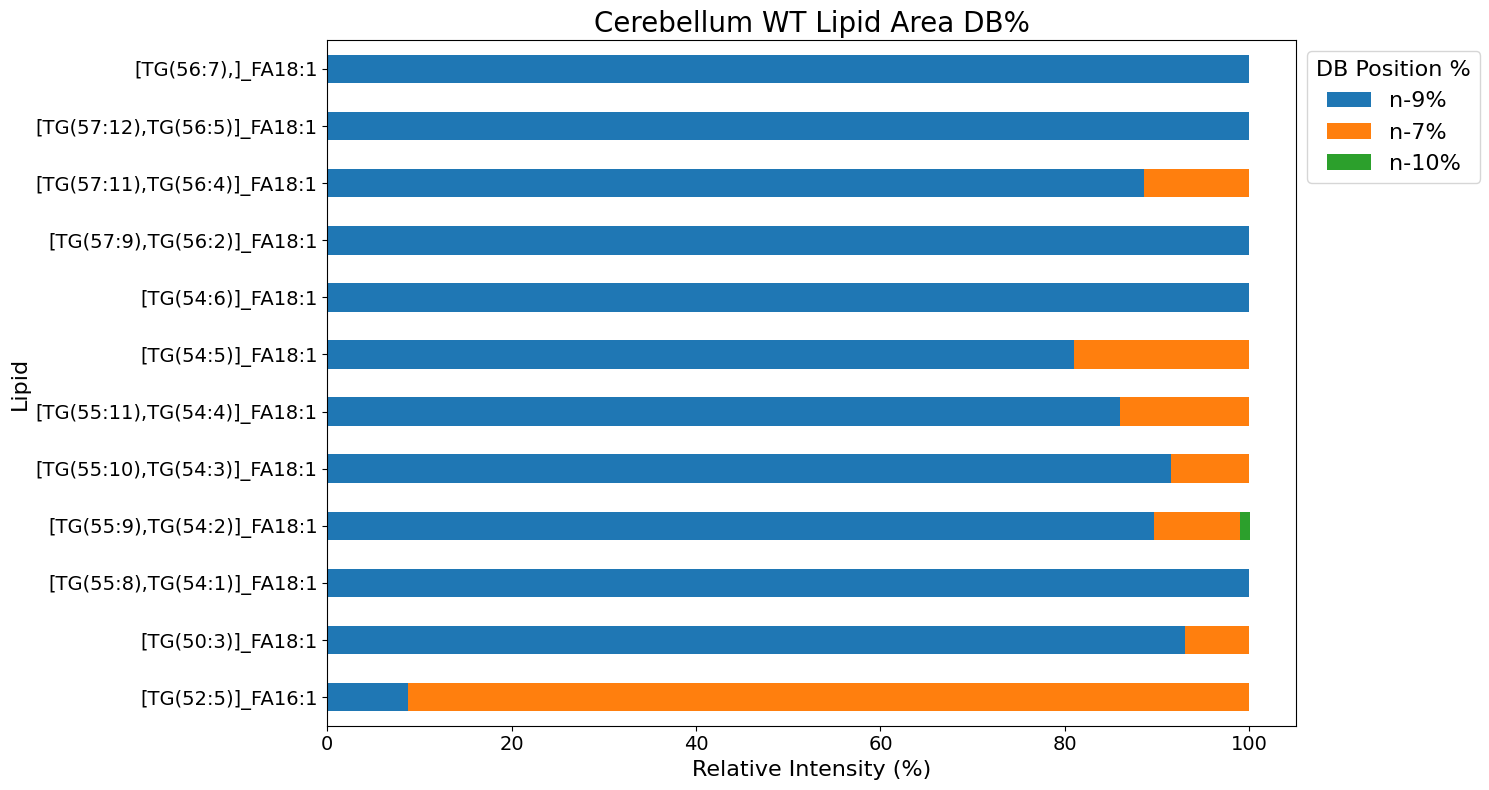

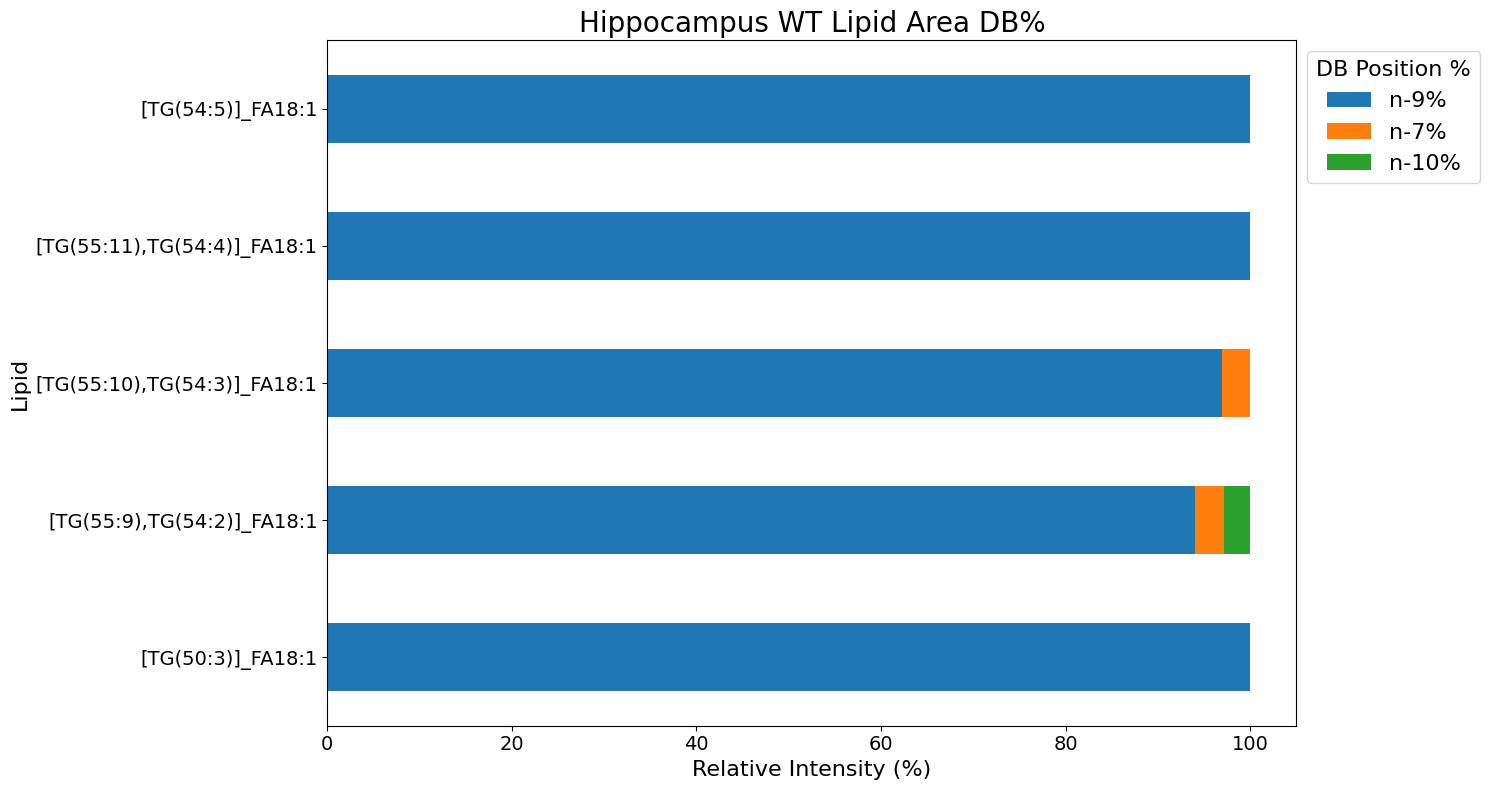

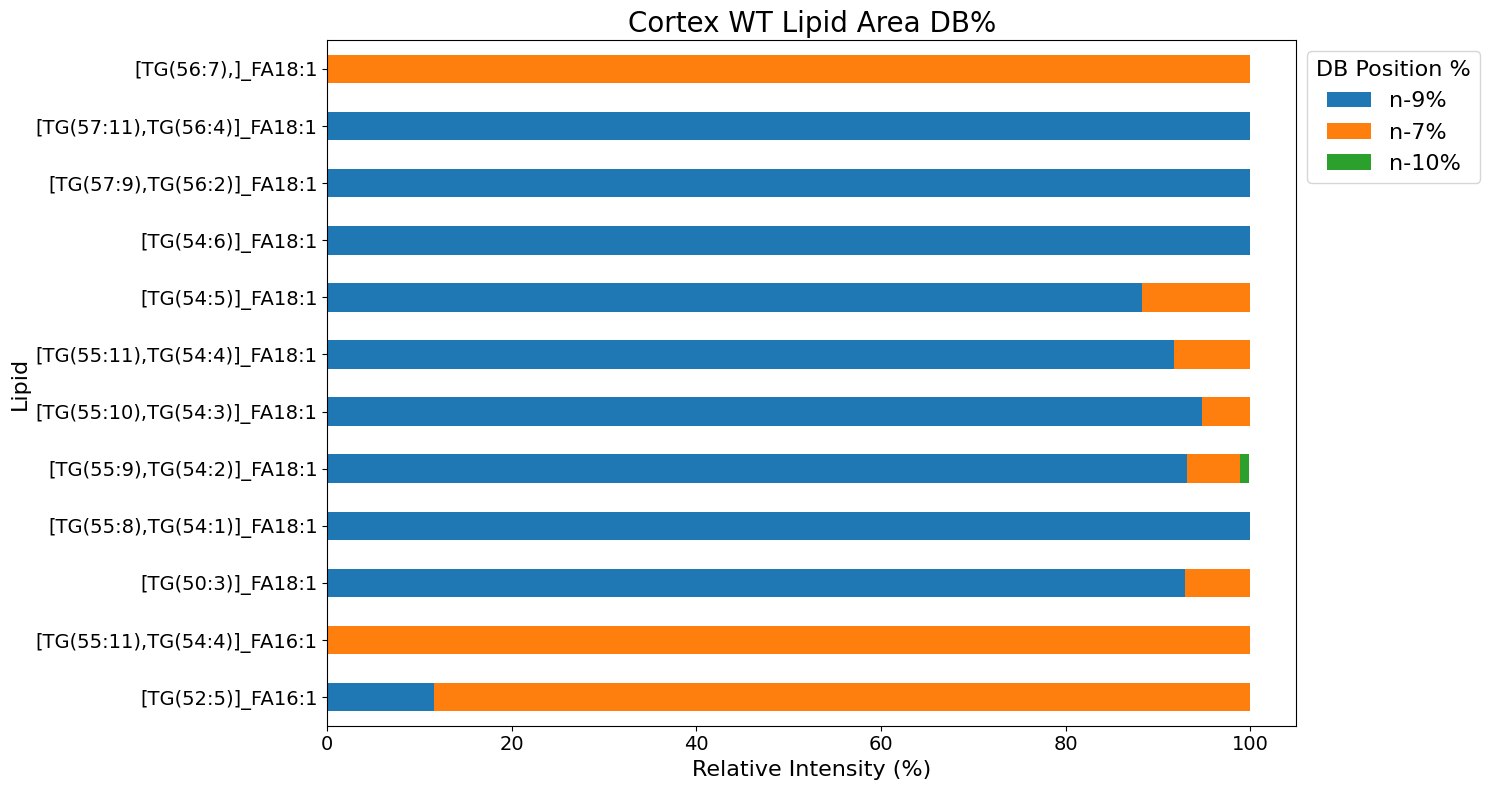

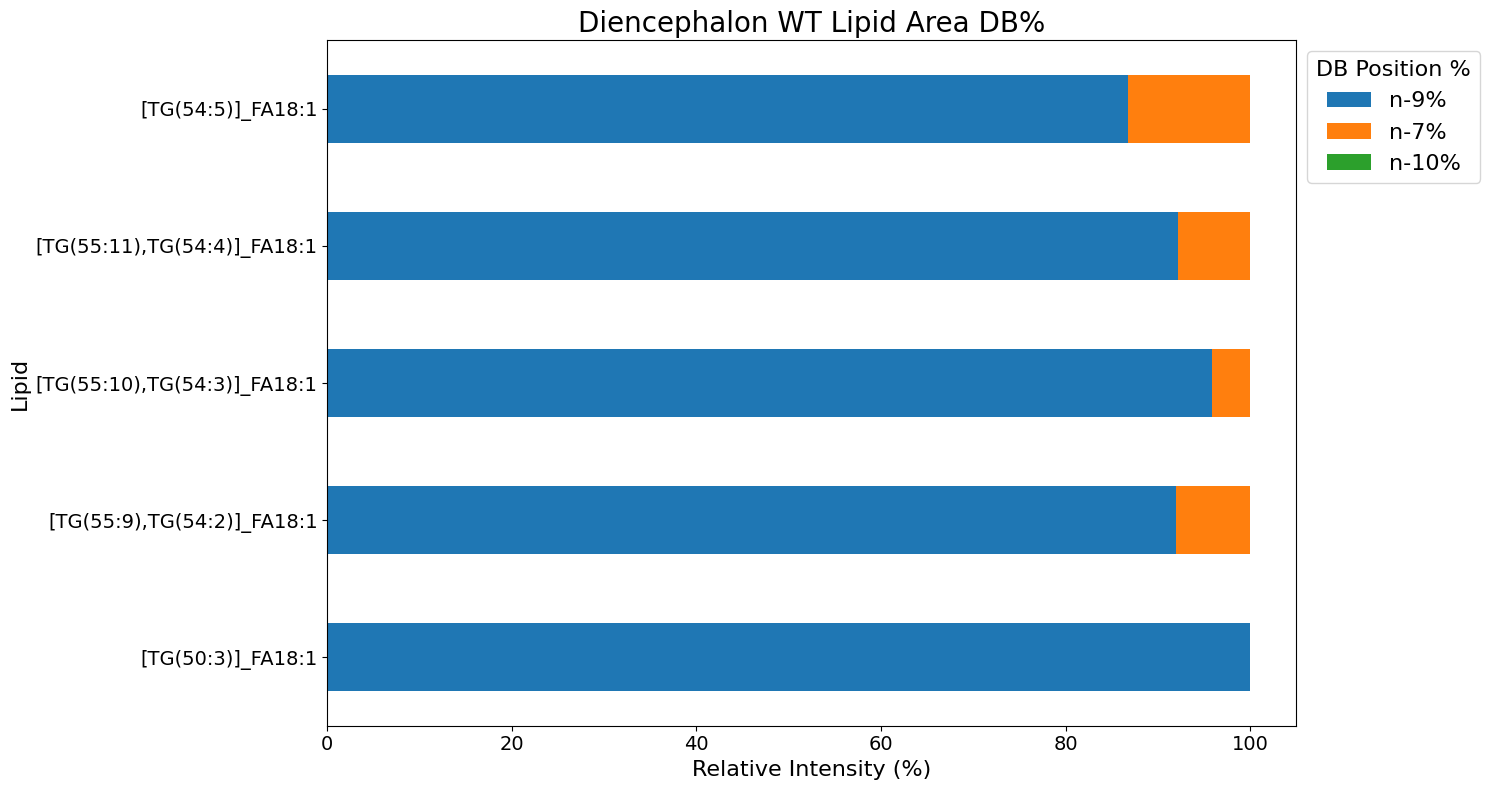

In [370]:
import matplotlib.pyplot as plt
import pandas as pd
import re

def combined_sort_key(lipid):
    fa16_1_key = '0' if 'FA16:1' in lipid else '1'
    tg_list = re.findall(r'TG\(\d+:\d+\)', lipid)
    tg_list_sorted = ', '.join(sorted(tg_list, key=lambda x: [int(i) for i in x[3:-1].split(':')]))
    return fa16_1_key + tg_list_sorted + lipid

def plot_brain_region_WT(df, region_name):
    # # Calculate percentages
    # for col in ['n-7', 'n-9', 'n-10', 'n-12']:
    #     df[col + '%'] = ((df[col] / df['Total Intensity']) * 100).round(1)

    # Reshape the DataFrame
    reshaped_df = df.melt(id_vars='Lipid', value_vars=['n-7%', 'n-9%', 'n-10%', 'n-12%'], var_name='db_pos', value_name='Percentage')

    # Create pivot table
    pivot_df = reshaped_df.pivot_table(index='Lipid', columns='db_pos', values='Percentage', aggfunc='sum')[['n-9%', 'n-7%', 'n-10%']]

    # Apply the combined sorting function to the Lipid index to create a sorting key
    pivot_df['Combined_Sort_Key'] = pivot_df.index.to_series().apply(combined_sort_key)

    # Sort the DataFrame by the combined sorting key
    pivot_df = pivot_df.sort_values(by='Combined_Sort_Key')

    # Drop the combined sorting key column
    pivot_df.drop('Combined_Sort_Key', axis=1, inplace=True)

    # Plotting
    pivot_df.plot(kind='barh', stacked=True, figsize=(15, 8))
    plt.xlabel('Relative Intensity (%)', fontsize = 16)
    plt.ylabel('Lipid', fontsize = 16)
    plt.title(f'{region_name} WT Lipid Area DB%', fontsize = 20)
    plt.legend(title='DB Position %', loc='upper left', bbox_to_anchor=(1, 1), fontsize = 16, title_fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)

    # # Saving the plot
    plt.savefig(f'Projects/FaceFats/plots/Barstack_area/{region_name}_WT_Truth_14Jan24.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'Projects/FaceFats/plots/Barstack_area/{region_name}_WT_Truth_14Jan24.pdf', dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()


df_brain_WT_cereb2
df_brain_WT_cortex2
df_brain_WT_hippo2
df_brain_WT_dienc2
# Example usage
plot_brain_region_WT(df_brain_WT_cereb2, 'Cerebellum')
plot_brain_region_WT(df_brain_WT_hippo2, 'Hippocampus')
plot_brain_region_WT(df_brain_WT_cortex2, 'Cortex')
plot_brain_region_WT(df_brain_WT_dienc2, 'Diencephalon')


In [363]:
# # Assuming d17 is your DataFrame
# # Filter d17 for rows where 'Lipid' column contains 'TG(52:5)'
# filtered_d16 = d17[d17['Lipid'].str.contains('TG\(54:4\)')]

# # The filtered_d16 DataFrame now contains only rows where 'Lipid' includes 'TG(52:5)'
# filtered_d16

# Create db columns for pivot table. n7 n9 n10 n12. Focus on Liver samples only

In [364]:
# df_liver = d18[d18['Biology'] == 'liver']

# # Creating the columns n-7, n-9, n-10, and n-12 in df_liver
# df_liver['n-7'] = 0.0
# df_liver['n-9'] = 0.0
# df_liver['n-10'] = 0.0
# df_liver['n-12'] = 0.0

# # Filling the columns based on db_pos and corresponding OzESI intensity
# for index, row in df_liver.iterrows():
#     db_pos = row['db']
#     oz_intensity = row['Area_DDT']
#     if db_pos in ['n-7', 'n-9', 'n-10', 'n-12']:
#         df_liver.at[index, db_pos] = oz_intensity
# df_liver

# #print unqiue lipids
# df_liver['Lipid'].unique()

In [365]:
# # Grouping by 'Lipid' and summing up the n-7, n-9, n-10, and n-12 columns
# df_liver2 = df_liver.groupby('Lipid')[['n-7', 'n-9', 'n-10', 'n-12']].sum().round(0).reset_index()
# #Creating a new column 'Total Intensity' in df_liver2
# df_liver2['Total_Intensity'] = df_liver2[['n-7', 'n-9', 'n-10', 'n-12']].sum(axis=1)

# # Create the 'FA' column
# df_liver2['FA'] = df_liver2['Lipid'].apply(lambda x: '16' if 'FA16:1' in x else ('18' if 'FA18:1' in x else 'Other'))

# # Sort the DataFrame by the 'FA' column
# df_liver2.sort_values(by='FA', inplace=True)
# # Displaying df4
# df_liver2

In [366]:
# # Creating a new dataframe df_liver3 from df_liver2
# df_liver3 = df_liver2.copy()

# # Calculating the relative intensity of each db_pos for each lipid
# for col in ['n-7', 'n-9', 'n-10', 'n-12']:
#     df_liver3[col + '%'] = ((df_liver3[col] / df_liver3['Total_Intensity']) * 100).round(1)


# # Function to determine the value for the FAC column
# def determine_fac(lipid):
#     if 'FA18:1' in lipid:
#         return 'FA18:1'
#     elif 'FA16:1' in lipid:
#         return 'FA16:1'
#     else:
#         return None  # or some other default value

# # Apply the function to the Lipid column to create the FAC column
# df_liver3['FAC'] = df_liver3['Lipid'].apply(determine_fac)

# import pandas as pd
# import re

# # Function to extract TG values
# def extract_tg(lipid):
#     # Regular expression pattern to match TG(##:#) or similar patterns
#     pattern = r'TG\(\d+:\d+\)'
#     matches = re.findall(pattern, lipid)
#     return ', '.join(matches) if matches else None

# # Apply the function to the Lipid column to create the TG column
# df_liver3['TG'] = df_liver3['Lipid'].apply(extract_tg)




# # Function to sort TG values within a cell
# def sort_tg_values(tg_cell):
#     if not pd.isna(tg_cell) and ', ' in tg_cell:
#         tg_list = tg_cell.split(', ')
#         tg_list_sorted = sorted(tg_list, key=lambda x: [int(i) for i in x[3:-1].split(':')])
#         return ', '.join(tg_list_sorted)
#     else:
#         return tg_cell

# # Apply the function to the TG column
# df_liver3['TG'] = df_liver3['TG'].apply(sort_tg_values)
# df_liver3 = df_liver3.sort_values(by=['FAC', 'TG'])
# import pandas as pd
# import re

# # Function to remove TG(##:0) patterns from the Lipid string
# def remove_tg_zero(lipid):
#     # Pattern to match TG(##:0)
#     pattern = r'TG\(\d+:0\)'
#     # Remove TG(##:0) patterns
#     new_lipid = re.sub(pattern, '', lipid)
#     # Remove any extra commas and spaces left after removal
#     new_lipid = re.sub(r',\s+', ', ', new_lipid).strip(', ')
#     return new_lipid

# # Apply the function to the Lipid column
# df_liver3['Lipid'] = df_liver3['Lipid'].apply(remove_tg_zero)

# # Continue with the rest of your code for sorting
# # ... [rest of your code] ...

# # Displaying df_l


# # Displaying df_liver3 with the new relative intensity columns
# df_liver3


# stacked barplot

In [367]:
# # Reshaping the DataFrame
# reshaped_df = df_liver3.melt(id_vars='Lipid', value_vars=['n-7%', 'n-9%', 'n-10%', 'n-12%'], var_name='db', value_name='Percentage')


# reshaped_df = reshaped_df[~reshaped_df['Lipid'].str.contains('FA18:2')]

# reshaped_df


# # Creating a pivot table
# pivot_df = reshaped_df.pivot_table(index='Lipid', columns='db', values='Percentage', aggfunc='sum')


# # Function to generate a combined sorting key
# def combined_sort_key(lipid):
#     # Check if lipid contains 'FA16:1'
#     fa16_1_key = '0' if 'FA16:1' in lipid else '1'  # '0' for FA16:1, '1' otherwise

#     # Extract and sort TG values
#     tg_list = re.findall(r'TG\(\d+:\d+\)', lipid)
#     tg_list_sorted = ', '.join(sorted(tg_list, key=lambda x: [int(i) for i in x[3:-1].split(':')]))

#     # Combine the keys
#     return fa16_1_key + tg_list_sorted + lipid

# # Apply the combined sorting function to the Lipid index to create a sorting key
# pivot_df['Combined_Sort_Key'] = pivot_df.index.to_series().apply(combined_sort_key)

# # Sort the DataFrame by the combined sorting key
# pivot_df = pivot_df.sort_values(by='Combined_Sort_Key')

# # Drop the combined sorting key column
# pivot_df.drop('Combined_Sort_Key', axis=1, inplace=True)

# # Reordering the columns to make n-9% appear first
# column_order = ['n-9%', 'n-7%', 'n-10%', 'n-12%']
# # column_order = ['n-9%', 'n-7%', 'n-10%']
# pivot_df = pivot_df[column_order]
# #delete FA18:2

# pivot_df
# # Plotting
# fig, ax = plt.subplots(figsize=(15, 8))
# pivot_df.plot(kind='barh', stacked=True, ax=ax)

# ax.set_xlabel('Relative Intensity (%)')
# ax.set_ylabel('Lipids')
# ax.set_title('Liver 5xFAD Lipids Area DB%')
# plt.xticks(rotation=90)

# # Moving the legend outside of the plot
# ax.legend(title='db', bbox_to_anchor=(1.05, 1), loc='upper left')

# # # Saving the plot as a PNG file
# # plt.savefig('Barstack_area/Liver_5xFAD_Area.png', dpi=300, bbox_inches='tight')
# # #save as pdf
# # plt.savefig('Barstack_area/Liver_5xFAD_Area.pdf', dpi=300, bbox_inches='tight')

# plt.tight_layout()
# plt.show()


In [368]:
# # Assuming d17 is your DataFrame
# # Filter d17 for rows where 'Lipid' column contains 'TG(52:5)'
# filtered_d16 = d17[d17['Lipid'].str.contains('TG\(54:4\)')]

# # The filtered_d16 DataFrame now contains only rows where 'Lipid' includes 'TG(52:5)'
# filtered_d16